In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11_MS

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [2]:
# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
torch.cuda.device_count()

4

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        #print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [8]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [9]:
# image transform for DG imagery
img_transform = Compose([
    Normalize(mean=[1460.1287, 1452.7002, 1511.6293, 2497.181], 
              std=[672.7396, 743.9062, 918.4014, 1196.6774])
])

In [10]:
# for i in [1,2,4,6]:
#     print(img_2m[i,:,:].mean().compute(), img_2m[i,:,:].std().compute())

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [11]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [12]:
bsize = 100

## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform, comb='bgrn') # will return RGB by default
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:1000], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform, comb='bgrn')
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform, comb='bgrn')

dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)

In [13]:
dg_dataset_train[0].shape

torch.Size([4, 64, 64])

In [14]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = bsize
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [15]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [16]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

## TRY A LOCAL IMPLEMENTATION OF UNET

In [17]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


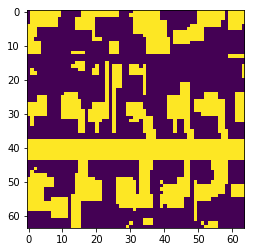

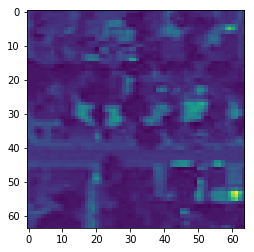

In [18]:
ind = 100
dg_dataset_train[ind], gt_dataset_train[ind]

plt.imshow(gt_dataset_train[ind].detach().numpy()[0,:,:])
plt.show()
plt.imshow(dg_dataset_train[ind].detach().numpy()[0,:,:])
plt.show()


In [19]:
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
# from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

## call outside training method, in loop

# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
bsize = 8 # smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
model = unet11_MS(num_bands=4, pretrained=False)

# set some parameters
lr = 0.0001

# make model parallel and on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)

optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)

print('batchsize, ', bsize)
mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0


###### specify DataLoaders
n_workers=0 # for some unknown reason, 0 is enabling all GPUs when 4 had previously done the trick. could be slower.
## GT
gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False, num_workers=n_workers)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False, num_workers=n_workers)


## DG
dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False, num_workers=n_workers)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False, num_workers=n_workers)


# record time for one epoch
rocs = []

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


num_bands is  4
Let's use 4 GPUs!
batchsize,  8
training...


In [20]:
t0 = time.time()
for epoch in range(100):
    
    try:
        te = time.time()

        epoch_i = epoch+1
        print('on epoch {}'.format(epoch_i))
        tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
        #print('hello')
        for i, (inputs_, targets_) in enumerate(tl):
            
            #print('hi')

            # get the inputs
            #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
            inputs, targets = variable(inputs_), variable(targets_)
            inputs.to(device)
            targets.to(device)

            outputs = model(inputs)

            # zero parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize            
            i_loss = criterion(outputs, targets)                
            i_loss.backward()
            optimizer.step()
            step+=1


            if i%10 == 0: # print/store every 10
                losses.append(i_loss)
                #running_loss += i_loss
                #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

        # get some numbers for the ROC curve
        if epoch_i%2 == 0:
            pred_y = outputs.cpu().data.numpy().squeeze().flatten()
            target_y = targets.cpu().data.numpy().flatten()
            tu = (i_loss, roc_auc_score(target_y,pred_y ))
            print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  
            rocs.append(tu[1])
            
            
        losses_ep.append(losses)
        te1 = time.time()
        print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))
        
        # early exit critera
        if len(rocs)>2:
            if (np.abs(rocs[-1] - rocs[-2]) < 0.009) and (rocs[-1] > 0.98):
                print('area under curve not changing significantly, exit loop')
                break_flag = True
                break
    
    except Exception as e:
        print('something happened')
        print(e)
        break
        
        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 882.4239165782928 seconds
on epoch 2
epoch: 2, LOSS=0.8749317526817322, ROC_AUC=0.8921270081869254 
time for epoch 2: 539.8587920665741 seconds
on epoch 3
time for epoch 3: 540.4883015155792 seconds
on epoch 4
epoch: 4, LOSS=0.7973778247833252, ROC_AUC=0.910656686458277 
time for epoch 4: 540.9862658977509 seconds
on epoch 5
time for epoch 5: 541.776064157486 seconds
on epoch 6
epoch: 6, LOSS=0.7205443382263184, ROC_AUC=0.9252768089689271 
time for epoch 6: 540.3658437728882 seconds
on epoch 7
time for epoch 7: 541.5051536560059 seconds
on epoch 8
epoch: 8, LOSS=0.6153277158737183, ROC_AUC=0.9443946891598165 
time for epoch 8: 544.312304019928 seconds
on epoch 9
time for epoch 9: 541.3496634960175 seconds
on epoch 10
epoch: 10, LOSS=0.5338266491889954, ROC_AUC=0.9577392317053022 
time for epoch 10: 540.3758955001831 seconds
on epoch 11
time for epoch 11: 539.9974267482758 seconds
on epoch 12
epoch: 12, LOSS=0.47560930252075195, ROC_AUC=0.9660718438955572 
time for epo

In [21]:
device

device(type='cuda')

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


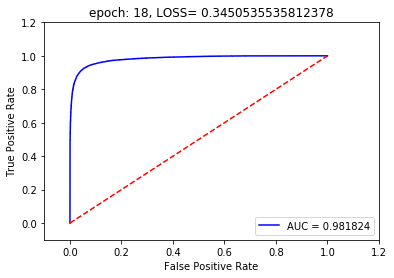

In [22]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('epoch: {}, LOSS= {}'.format(epoch_i, i_loss))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Performance on the Validation set

In [23]:
model.eval()

DataParallel(
  (module): UNet11_MS(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace)
      (13): Conv2d(512, 512, kernel_siz

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Validation batch: 0, LOSS=0.44052842259407043, ROC_AUC=0.9677437356988754 


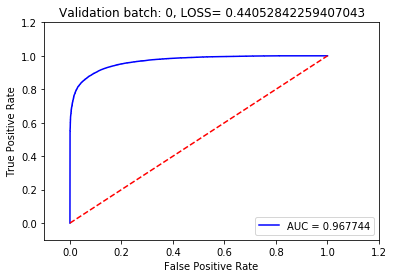

Validation batch: 1, LOSS=0.47885245084762573, ROC_AUC=0.9649878453803993 


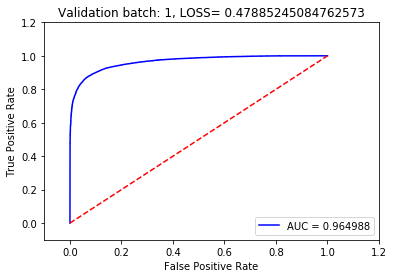

Validation batch: 2, LOSS=0.306970477104187, ROC_AUC=0.9796630967222697 


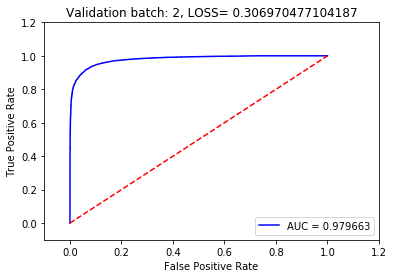

Validation batch: 3, LOSS=0.5320737361907959, ROC_AUC=0.9566525693001723 


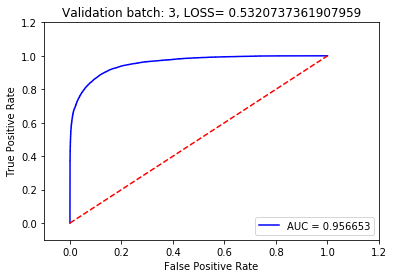

Validation batch: 4, LOSS=0.30022022128105164, ROC_AUC=0.982581485116255 


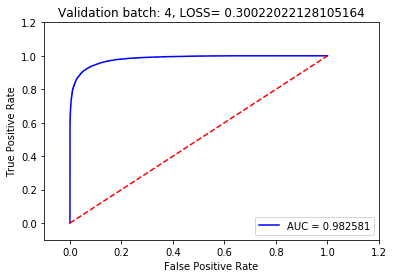

Validation batch: 5, LOSS=0.4210893511772156, ROC_AUC=0.966037617228017 


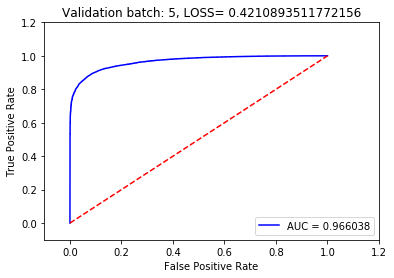

Validation batch: 6, LOSS=0.5268933773040771, ROC_AUC=0.9637389358618693 


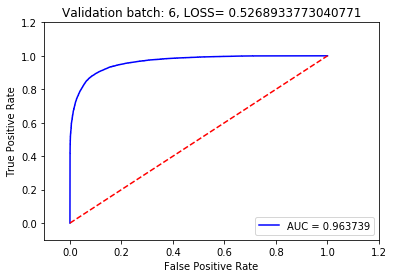

Validation batch: 7, LOSS=0.40437591075897217, ROC_AUC=0.967332136215546 


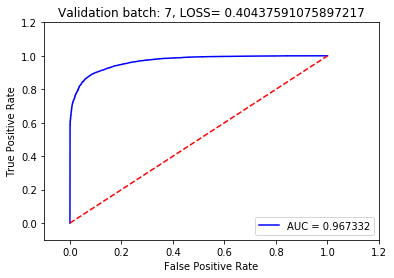

Validation batch: 8, LOSS=0.4390280544757843, ROC_AUC=0.9677764193432974 


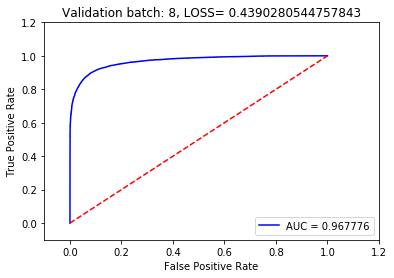

Validation batch: 9, LOSS=0.4390127658843994, ROC_AUC=0.9673073128530045 


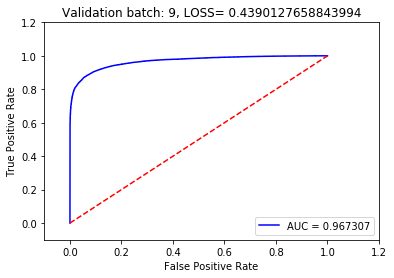

Validation batch: 10, LOSS=0.5986220240592957, ROC_AUC=0.948088974958982 


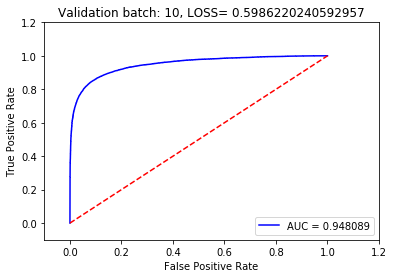

Validation batch: 11, LOSS=0.3558896780014038, ROC_AUC=0.9697676155626302 


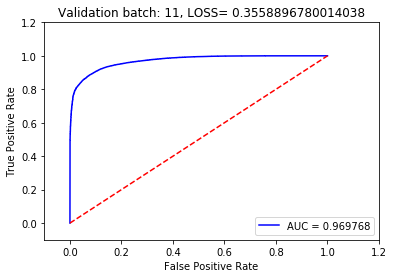

Validation batch: 12, LOSS=0.3569997549057007, ROC_AUC=0.9804971468200515 


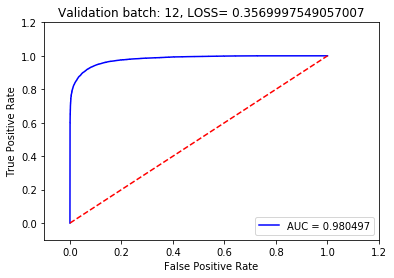

Validation batch: 13, LOSS=0.5162340402603149, ROC_AUC=0.9580287337290878 


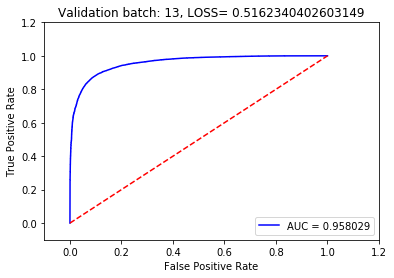

Validation batch: 14, LOSS=0.5701009631156921, ROC_AUC=0.9564983027992899 


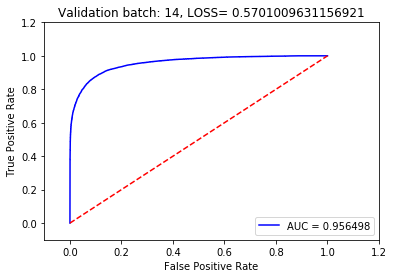

Validation batch: 15, LOSS=0.4971783459186554, ROC_AUC=0.9638636020434557 


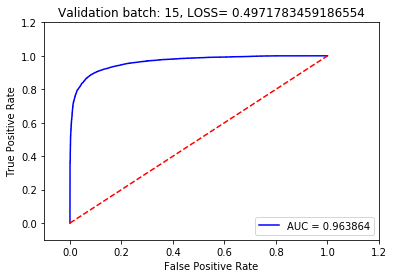

Validation batch: 16, LOSS=0.5560453534126282, ROC_AUC=0.9529545999298008 


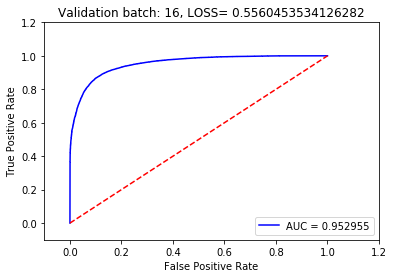

Validation batch: 17, LOSS=0.6569456458091736, ROC_AUC=0.9442063918557823 


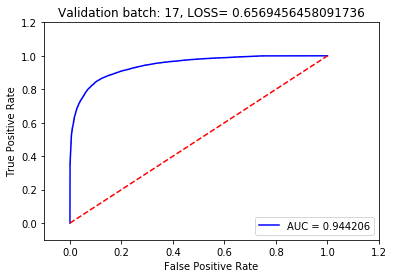

Validation batch: 18, LOSS=0.40174853801727295, ROC_AUC=0.975909104689462 


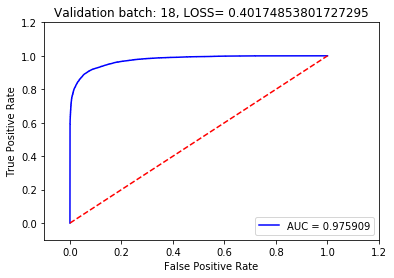

Validation batch: 19, LOSS=0.6730260848999023, ROC_AUC=0.9382579711425332 


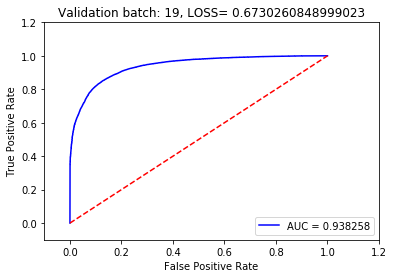

Validation batch: 20, LOSS=0.5008276700973511, ROC_AUC=0.9645588355103436 


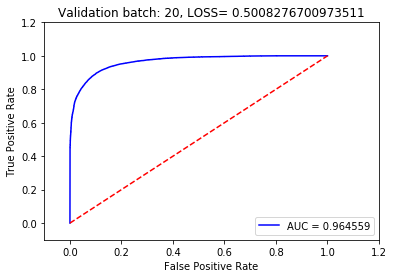

Validation batch: 21, LOSS=0.49376487731933594, ROC_AUC=0.9599640259733249 


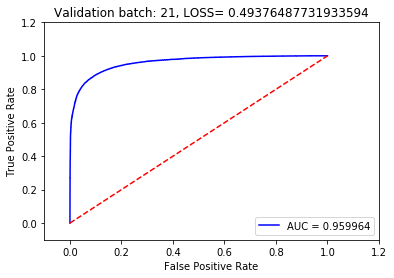

Validation batch: 22, LOSS=0.4136979579925537, ROC_AUC=0.9685938842688289 


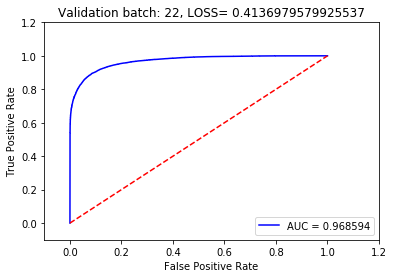

Validation batch: 23, LOSS=0.5037873387336731, ROC_AUC=0.9608551951709023 


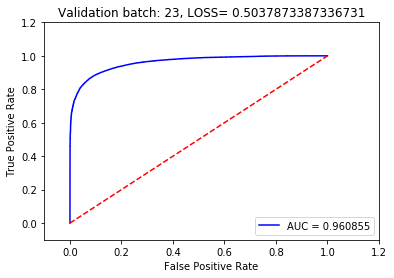

Validation batch: 24, LOSS=0.5084413290023804, ROC_AUC=0.9632362734852888 


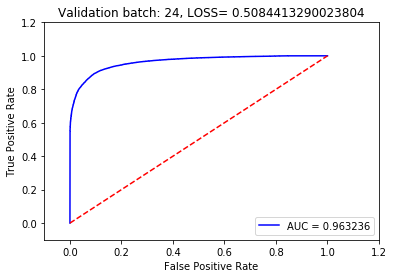

Validation batch: 25, LOSS=0.5204459428787231, ROC_AUC=0.9594609422446139 


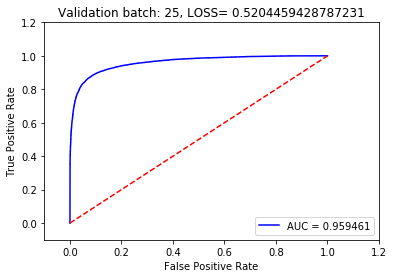

Validation batch: 26, LOSS=0.4212999939918518, ROC_AUC=0.9664383453980608 


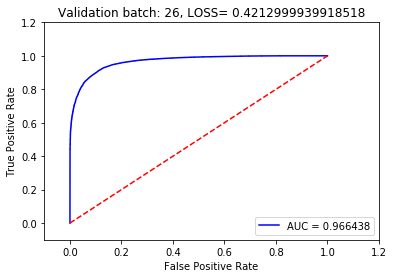

Validation batch: 27, LOSS=0.5427591800689697, ROC_AUC=0.9568688568124863 


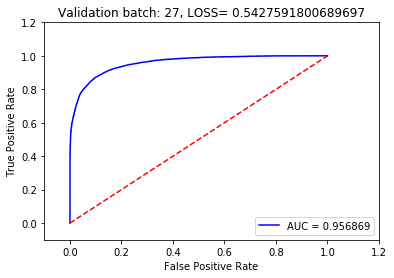

Validation batch: 28, LOSS=0.6403428316116333, ROC_AUC=0.940485644379382 


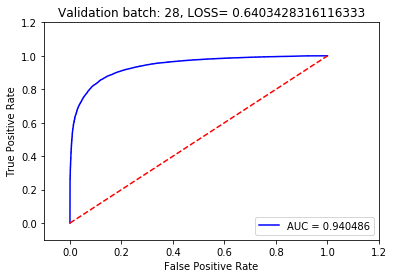

Validation batch: 29, LOSS=0.5175861716270447, ROC_AUC=0.9658613130586899 


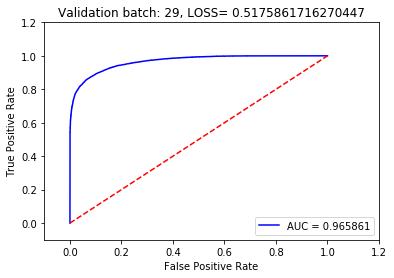

Validation batch: 30, LOSS=0.5437718629837036, ROC_AUC=0.9558143637172629 


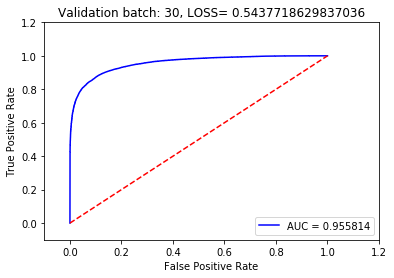

Validation batch: 31, LOSS=0.5329447984695435, ROC_AUC=0.9559784582071319 


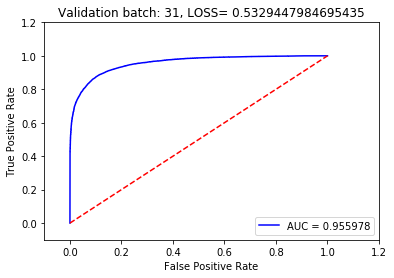

Validation batch: 32, LOSS=0.5008730888366699, ROC_AUC=0.9656457910739842 


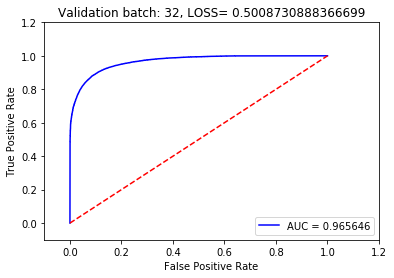

Validation batch: 33, LOSS=0.6839922070503235, ROC_AUC=0.9383366206854856 


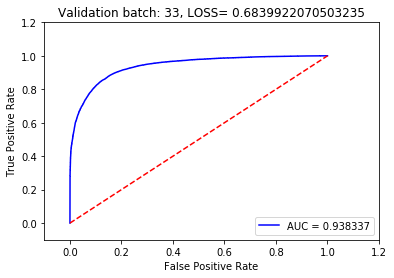

Validation batch: 34, LOSS=0.29931002855300903, ROC_AUC=0.9773009213365714 


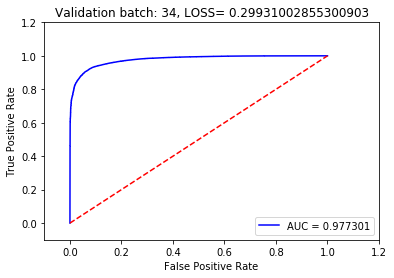

Validation batch: 35, LOSS=0.5112791657447815, ROC_AUC=0.9571470444091472 


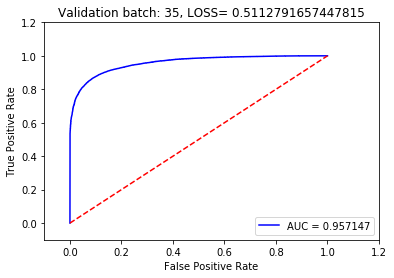

Validation batch: 36, LOSS=0.49490058422088623, ROC_AUC=0.9710919865875159 


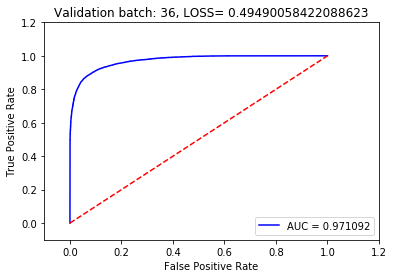

Validation batch: 37, LOSS=0.5419489741325378, ROC_AUC=0.9552903537588521 


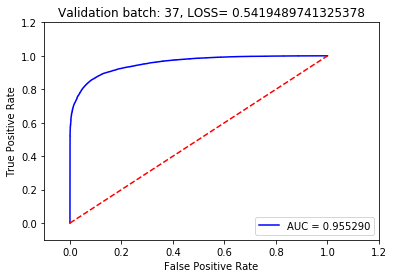

Validation batch: 38, LOSS=0.7021656036376953, ROC_AUC=0.9439820297227848 


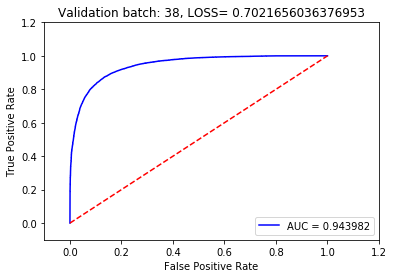

Validation batch: 39, LOSS=0.35590121150016785, ROC_AUC=0.979691283984137 


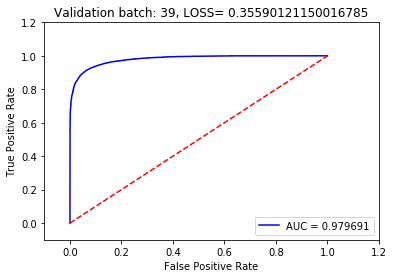

Validation batch: 40, LOSS=0.6006601452827454, ROC_AUC=0.9439512467680773 


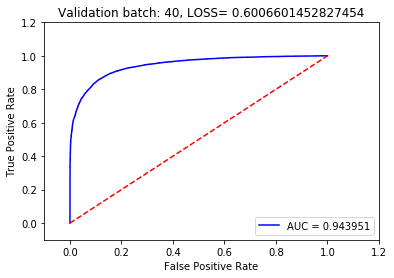

Validation batch: 41, LOSS=0.47983336448669434, ROC_AUC=0.9678056933410959 


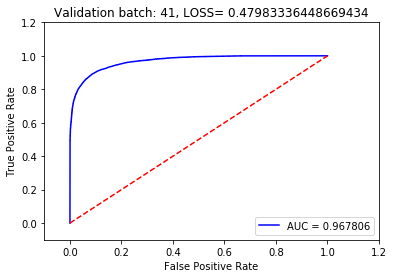

Validation batch: 42, LOSS=0.38098883628845215, ROC_AUC=0.9677558486999875 


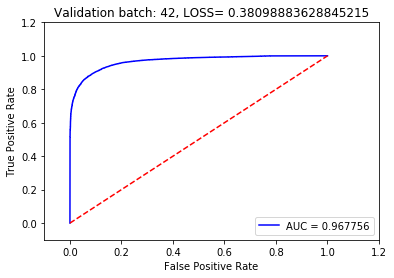

Validation batch: 43, LOSS=0.50812828540802, ROC_AUC=0.9544868845473056 


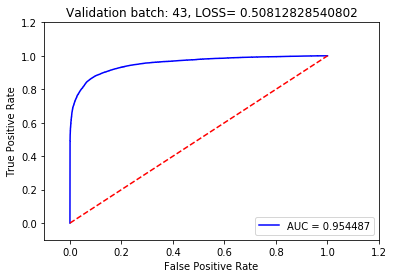

Validation batch: 44, LOSS=0.4989648163318634, ROC_AUC=0.9643197792374426 


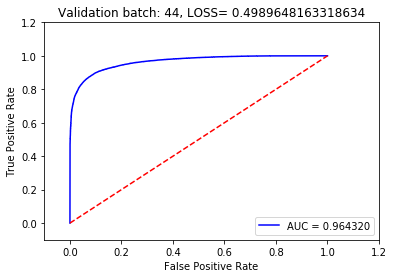

Validation batch: 45, LOSS=0.5868047475814819, ROC_AUC=0.9499083457970122 


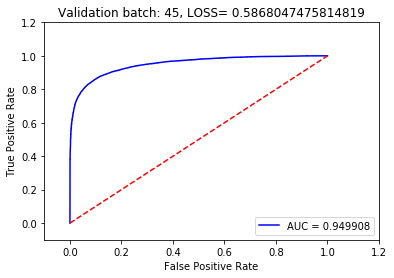

Validation batch: 46, LOSS=0.571677029132843, ROC_AUC=0.9535695894537877 


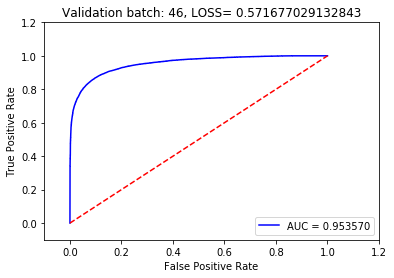

Validation batch: 47, LOSS=0.5779675841331482, ROC_AUC=0.952954337587548 


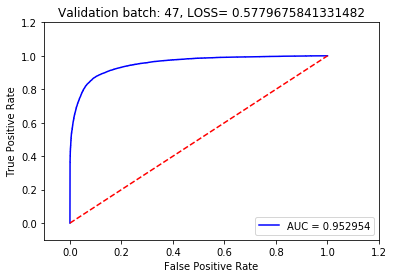

Validation batch: 48, LOSS=0.5199348330497742, ROC_AUC=0.9518362559800085 


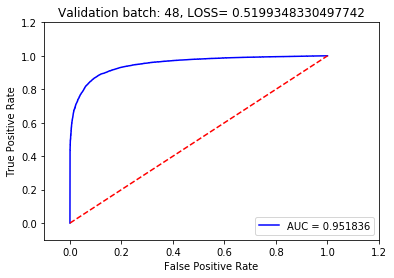

Validation batch: 49, LOSS=0.4072640538215637, ROC_AUC=0.9726728965898309 


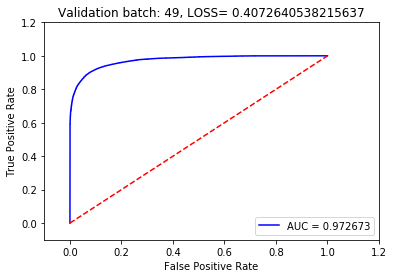

Validation batch: 50, LOSS=0.44175148010253906, ROC_AUC=0.9728397085144382 


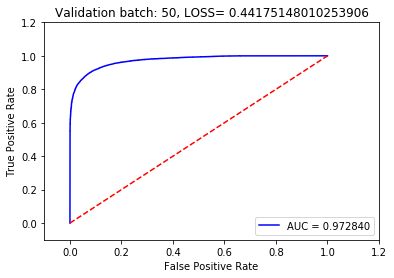

Validation batch: 51, LOSS=0.48813652992248535, ROC_AUC=0.9621970534460038 


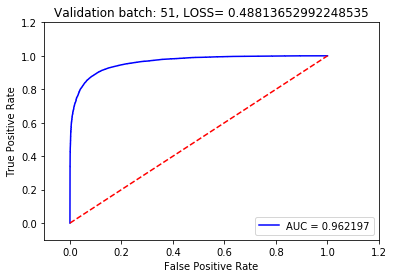

Validation batch: 52, LOSS=0.36250394582748413, ROC_AUC=0.981395689274261 


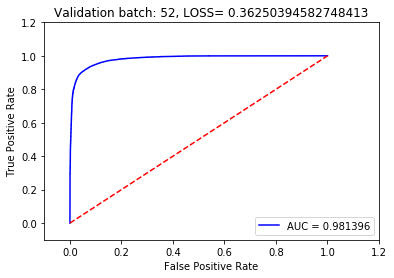

Validation batch: 53, LOSS=0.4243602752685547, ROC_AUC=0.9668818098801439 


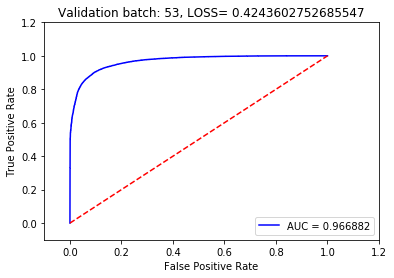

Validation batch: 54, LOSS=0.6940418481826782, ROC_AUC=0.9318775428514035 


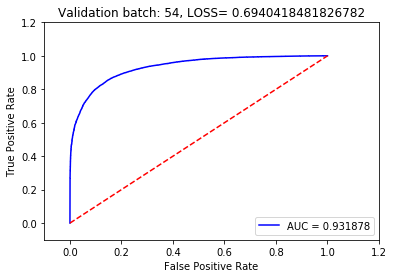

Validation batch: 55, LOSS=0.4509483873844147, ROC_AUC=0.9648916832952367 


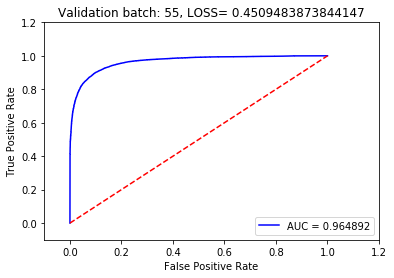

Validation batch: 56, LOSS=0.5976737141609192, ROC_AUC=0.948975767546755 


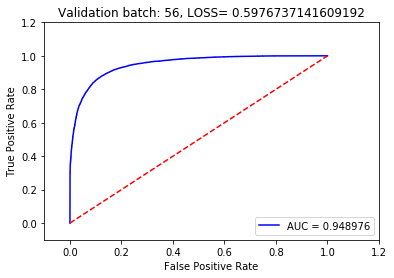

Validation batch: 57, LOSS=0.3714061975479126, ROC_AUC=0.9807916223815343 


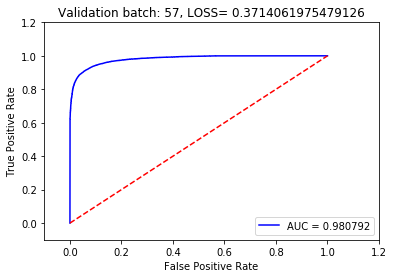

Validation batch: 58, LOSS=0.5300703644752502, ROC_AUC=0.9541583571570746 


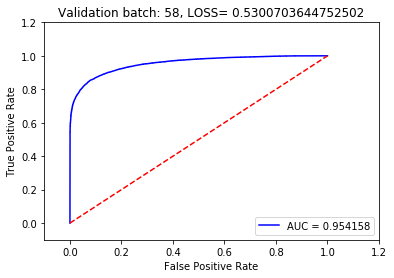

Validation batch: 59, LOSS=0.5474203824996948, ROC_AUC=0.9606006287642505 


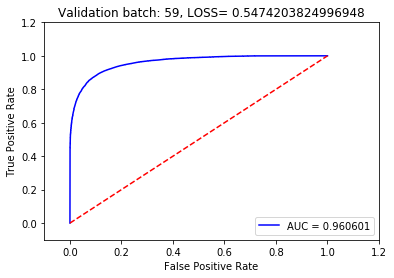

Validation batch: 60, LOSS=0.583690881729126, ROC_AUC=0.9524808021164779 


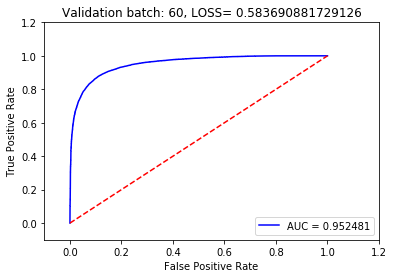

Validation batch: 61, LOSS=0.4767841100692749, ROC_AUC=0.9667979188977536 


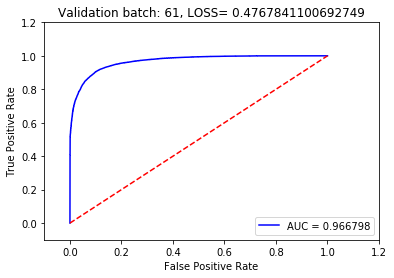

Validation batch: 62, LOSS=0.42004841566085815, ROC_AUC=0.9696750048278671 


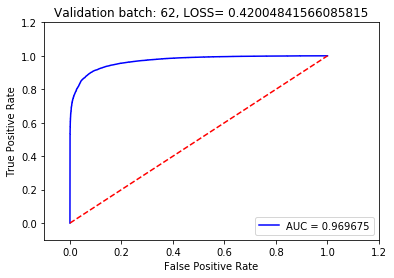

Validation batch: 63, LOSS=0.5009642243385315, ROC_AUC=0.9655484531679623 


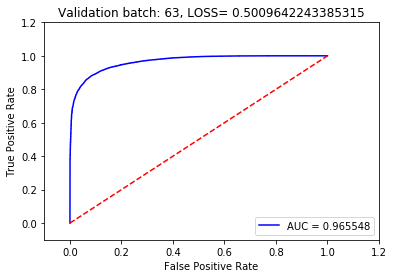

Validation batch: 64, LOSS=0.5348844528198242, ROC_AUC=0.9551515080259935 


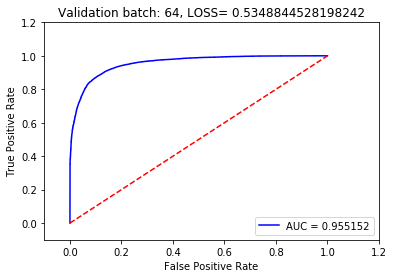

Validation batch: 65, LOSS=0.5982003211975098, ROC_AUC=0.9472862169759061 


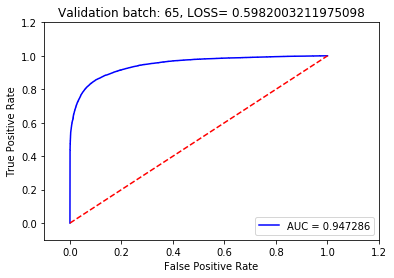

Validation batch: 66, LOSS=0.5987023115158081, ROC_AUC=0.9527689616984292 


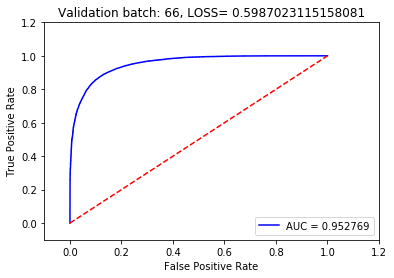

Validation batch: 67, LOSS=0.6205863952636719, ROC_AUC=0.9524615861351494 


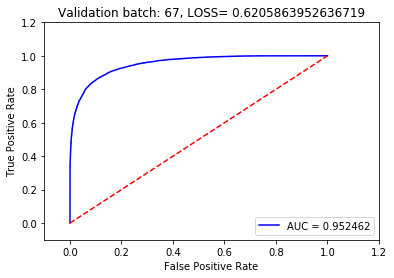

Validation batch: 68, LOSS=0.3765476942062378, ROC_AUC=0.9733425142773918 


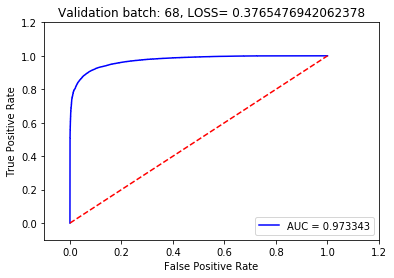

Validation batch: 69, LOSS=0.40728214383125305, ROC_AUC=0.9729294996895956 


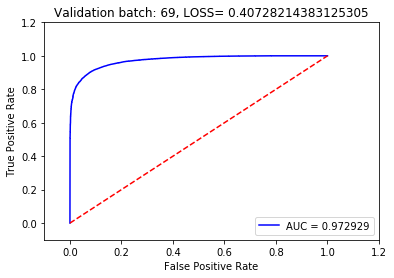

Validation batch: 70, LOSS=0.6759732961654663, ROC_AUC=0.9347961069115946 


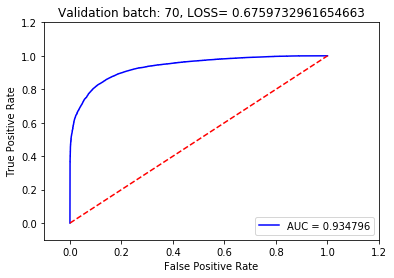

Validation batch: 71, LOSS=0.6241230368614197, ROC_AUC=0.9442027964205164 


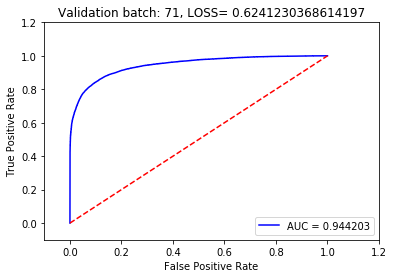

Validation batch: 72, LOSS=0.6347225308418274, ROC_AUC=0.9464949712031027 


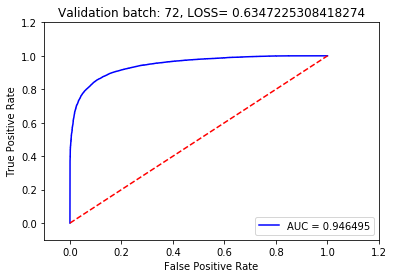

Validation batch: 73, LOSS=0.4294467568397522, ROC_AUC=0.9689889709244046 


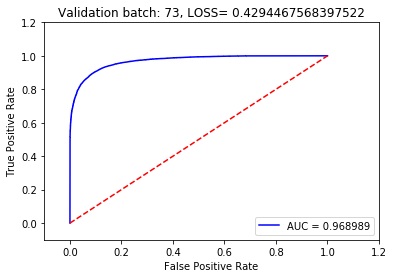

Validation batch: 74, LOSS=0.4763715863227844, ROC_AUC=0.9659593505489795 


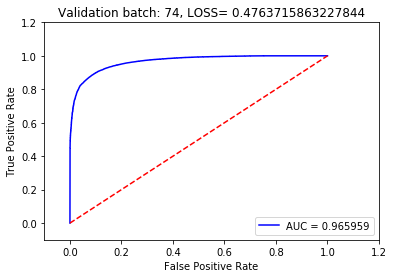

Validation batch: 75, LOSS=0.5834869146347046, ROC_AUC=0.9539058668691959 


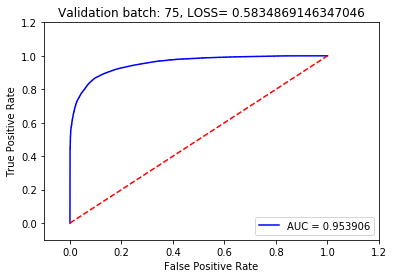

Validation batch: 76, LOSS=0.5861807465553284, ROC_AUC=0.9586475188503027 


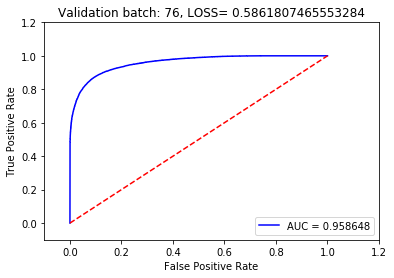

Validation batch: 77, LOSS=0.39353644847869873, ROC_AUC=0.971428142501052 


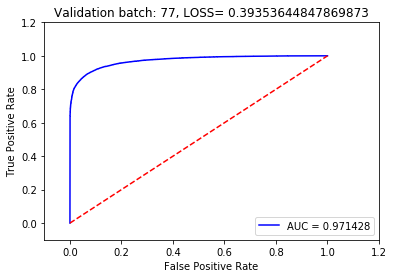

Validation batch: 78, LOSS=0.5578335523605347, ROC_AUC=0.9549023618506498 


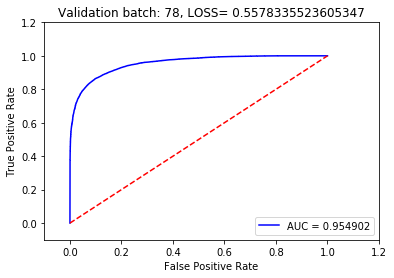

Validation batch: 79, LOSS=0.6415418982505798, ROC_AUC=0.9438563818760417 


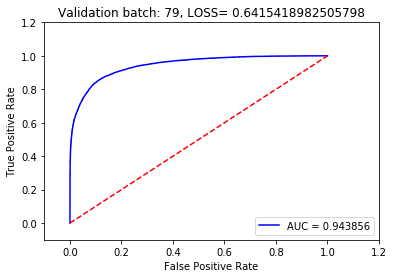

Validation batch: 80, LOSS=0.4494578242301941, ROC_AUC=0.9696024472869907 


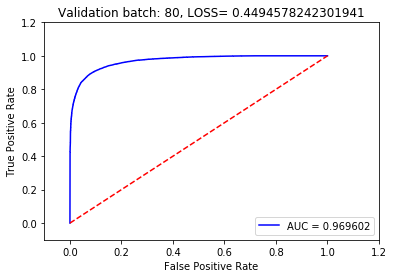

Validation batch: 81, LOSS=0.49867483973503113, ROC_AUC=0.9636280612695729 


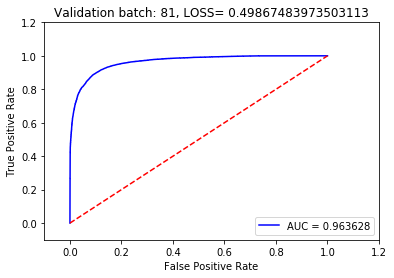

Validation batch: 82, LOSS=0.437512069940567, ROC_AUC=0.9718552258842887 


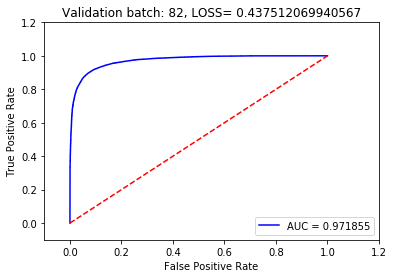

Validation batch: 83, LOSS=0.5337345004081726, ROC_AUC=0.9584928372778238 


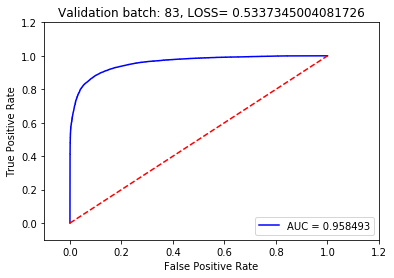

Validation batch: 84, LOSS=0.3254970908164978, ROC_AUC=0.9753821012917988 


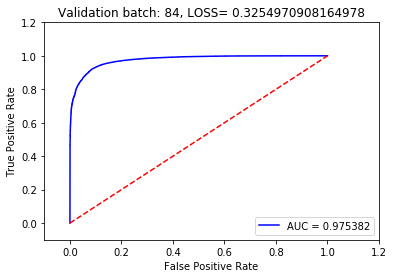

Validation batch: 85, LOSS=0.49712449312210083, ROC_AUC=0.9581407145580185 


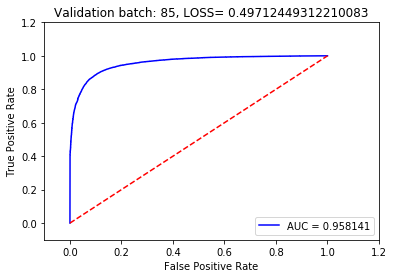

Validation batch: 86, LOSS=0.3621935248374939, ROC_AUC=0.9724144576673093 


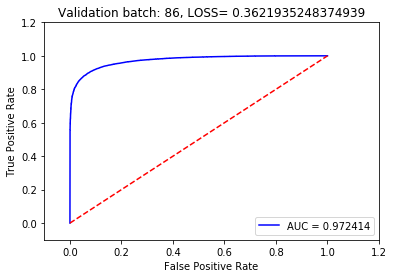

Validation batch: 87, LOSS=0.3788923919200897, ROC_AUC=0.9773015891004987 


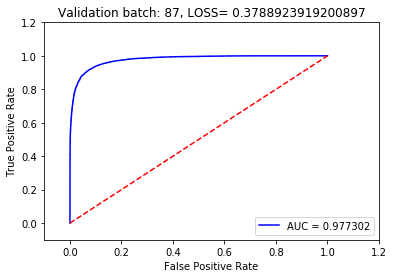

Validation batch: 88, LOSS=0.38099348545074463, ROC_AUC=0.9721524456715087 


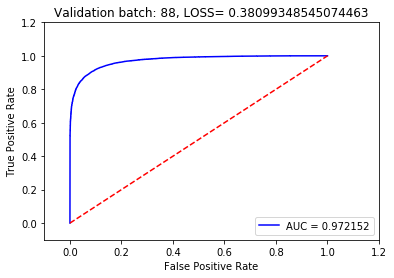

Validation batch: 89, LOSS=0.6598615646362305, ROC_AUC=0.952908144365067 


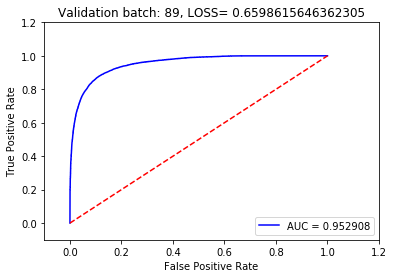

Validation batch: 90, LOSS=0.4933169484138489, ROC_AUC=0.9612271339157475 


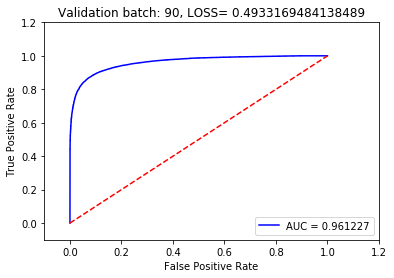

Validation batch: 91, LOSS=0.41189366579055786, ROC_AUC=0.9715068206186326 


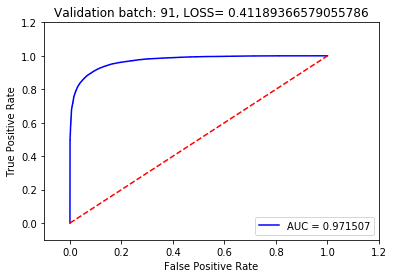

Validation batch: 92, LOSS=0.4146169126033783, ROC_AUC=0.9687023155431017 


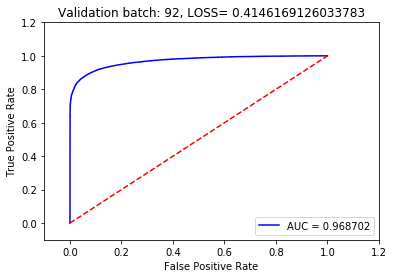

Validation batch: 93, LOSS=0.4411075711250305, ROC_AUC=0.96633328266954 


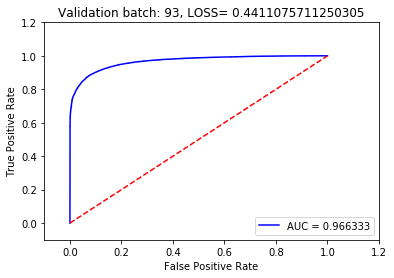

Validation batch: 94, LOSS=0.4908059239387512, ROC_AUC=0.9628690748212455 


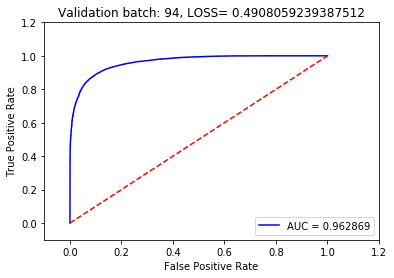

Validation batch: 95, LOSS=0.46299517154693604, ROC_AUC=0.9606547741831511 


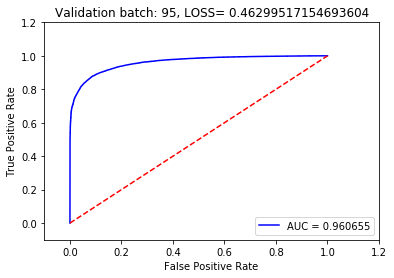

Validation batch: 96, LOSS=0.45023542642593384, ROC_AUC=0.961103754618634 


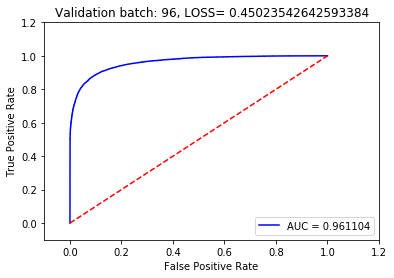

Validation batch: 97, LOSS=0.37130290269851685, ROC_AUC=0.9720170851176504 


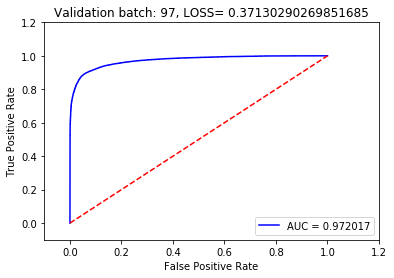

Validation batch: 98, LOSS=0.7916809320449829, ROC_AUC=0.9191550381415832 


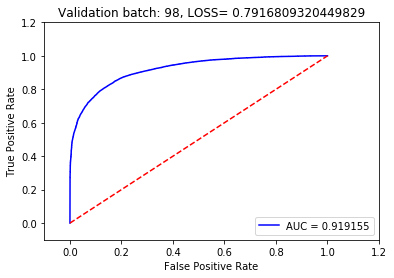

Validation batch: 99, LOSS=0.391848087310791, ROC_AUC=0.9717726380449005 


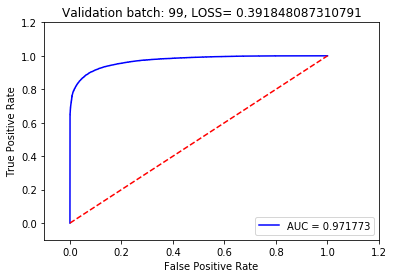

Validation batch: 100, LOSS=0.4391268491744995, ROC_AUC=0.9666751966726678 


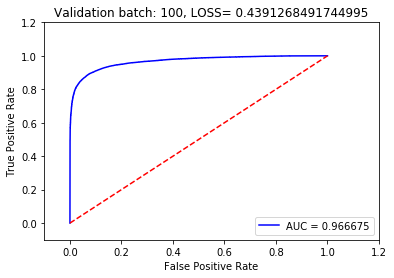

Validation batch: 101, LOSS=0.40229904651641846, ROC_AUC=0.9685275461396696 


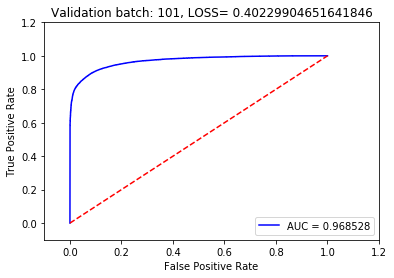

Validation batch: 102, LOSS=0.7487778663635254, ROC_AUC=0.93678750435781 


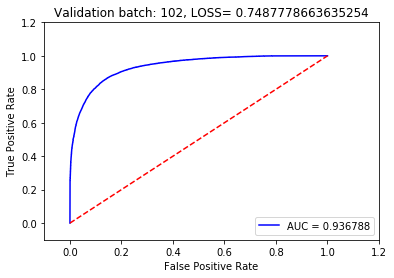

Validation batch: 103, LOSS=0.34883981943130493, ROC_AUC=0.9749012511408824 


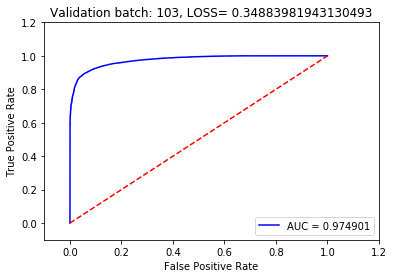

Validation batch: 104, LOSS=0.41879650950431824, ROC_AUC=0.9728661623313059 


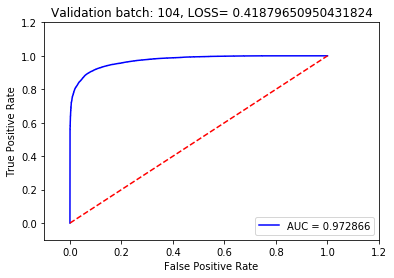

Validation batch: 105, LOSS=0.7260164022445679, ROC_AUC=0.9342175375710331 


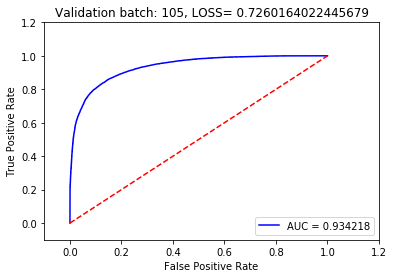

Validation batch: 106, LOSS=0.56028813123703, ROC_AUC=0.9538395909559612 


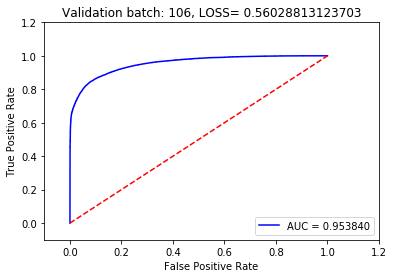

Validation batch: 107, LOSS=0.36731693148612976, ROC_AUC=0.9708391285997149 


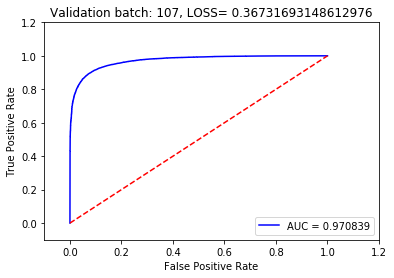

Validation batch: 108, LOSS=0.5909367799758911, ROC_AUC=0.9524126674354467 


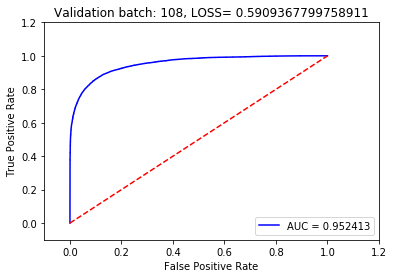

Validation batch: 109, LOSS=0.2358890175819397, ROC_AUC=0.9862206068701488 


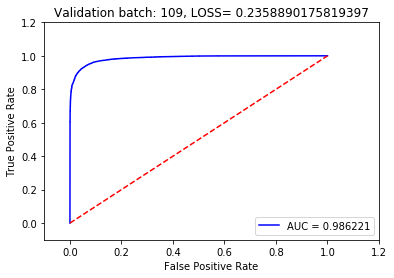

Validation batch: 110, LOSS=0.3978351354598999, ROC_AUC=0.971076841801987 


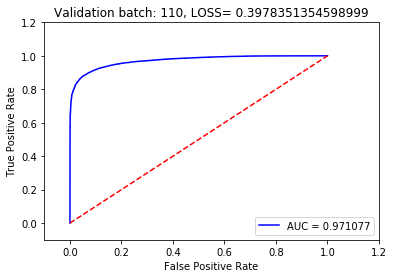

Validation batch: 111, LOSS=0.39264607429504395, ROC_AUC=0.9772166248639611 


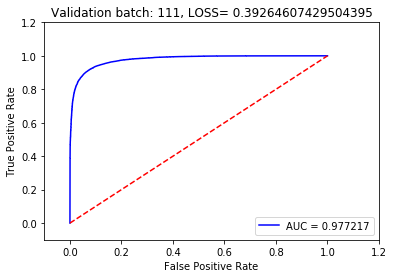

Validation batch: 112, LOSS=0.5162093043327332, ROC_AUC=0.9626886196467639 


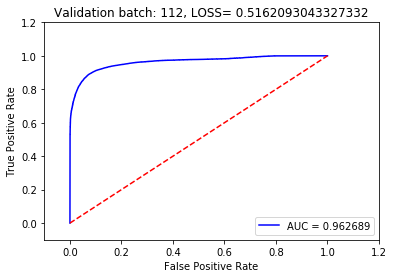

Validation batch: 113, LOSS=0.4664975702762604, ROC_AUC=0.9666189841927812 


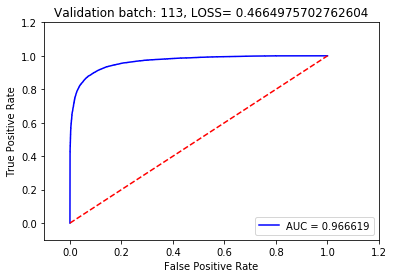

Validation batch: 114, LOSS=0.3900781273841858, ROC_AUC=0.9708594335271005 


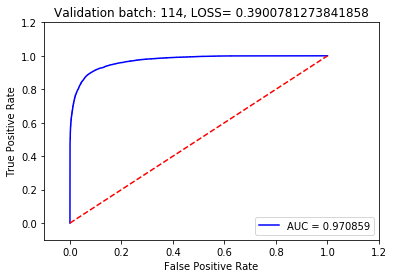

Validation batch: 115, LOSS=0.5148912072181702, ROC_AUC=0.9574414807727851 


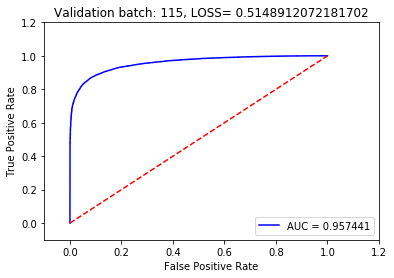

Validation batch: 116, LOSS=0.4051780700683594, ROC_AUC=0.9712457740670286 


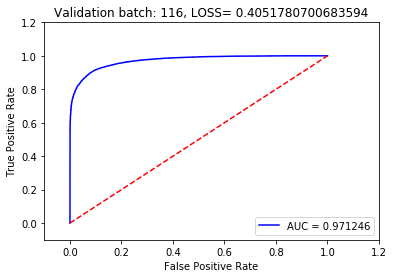

Validation batch: 117, LOSS=0.41980594396591187, ROC_AUC=0.9683932620374047 


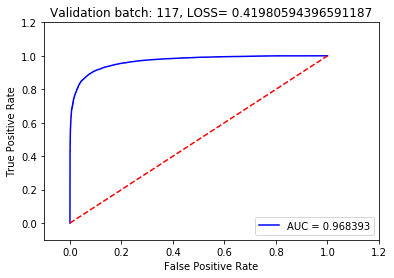

Validation batch: 118, LOSS=0.40728116035461426, ROC_AUC=0.9732860766599959 


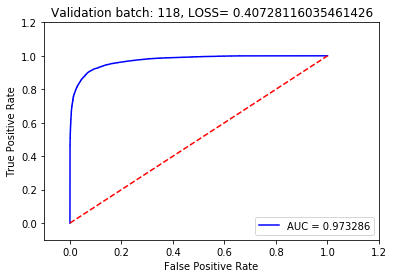

Validation batch: 119, LOSS=0.5491943359375, ROC_AUC=0.953255761390444 


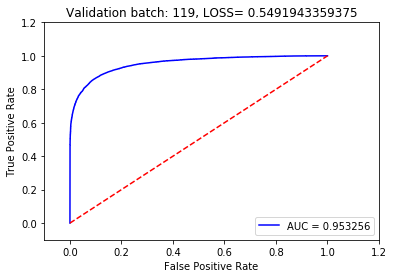

Validation batch: 120, LOSS=0.41121968626976013, ROC_AUC=0.9646771154334183 


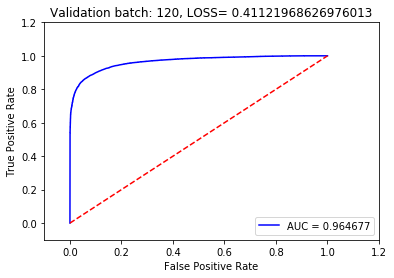

Validation batch: 121, LOSS=0.4671115279197693, ROC_AUC=0.9664034431238111 


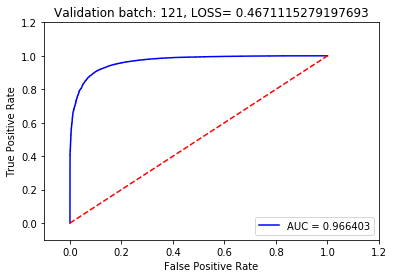

Validation batch: 122, LOSS=0.4572407603263855, ROC_AUC=0.9666425515625565 


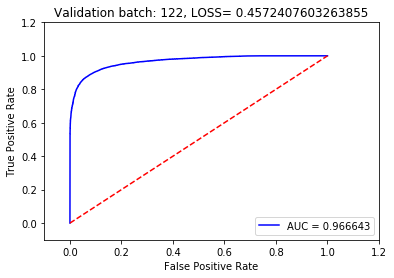

Validation batch: 123, LOSS=0.5416574478149414, ROC_AUC=0.9553308041195651 


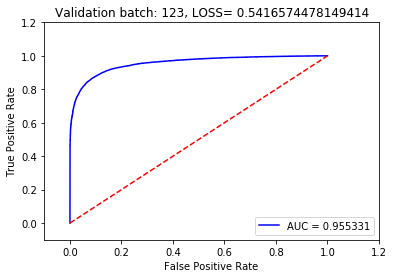

Validation batch: 124, LOSS=0.48324117064476013, ROC_AUC=0.9636088194556096 


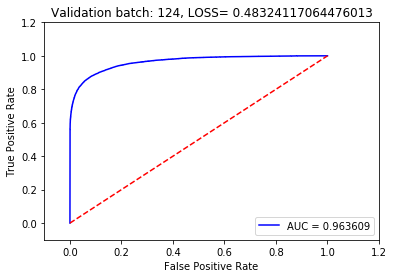

In [24]:
##### Validation data
## ground truth
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


## DG
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


# define a zipped object for iterating
zl = zip(dg_dl_val, gt_dl_val)

# some lists for plotting all batch ROC curves
all_fpr = []
all_tpr = []
all_thresh = []
all_roc_auc = []
for i_val, (inputs_, targets_) in enumerate(zl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        # evaluate
        outputs = model(inputs)
        
        # record loss
        v_loss = criterion(outputs, targets)
        
        # convert to numpy and get ROC params
        pred_y_val = outputs.cpu().data.numpy().squeeze().flatten()
        #pred_y_val[pred_y_val > 0] = 1.
        #pred_y_val[pred_y_val <=0] = 0.
        target_y_val = targets.cpu().data.numpy().flatten()
        tu = (v_loss, roc_auc_score(target_y_val,pred_y_val ))
        print ('Validation batch: {}, LOSS={}, ROC_AUC={} '.format(i_val, *tu))  

        # calculate FPR and TPR, and area-under-curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y_val,pred_y_val)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
        # append to lists
        all_fpr.append(false_positive_rate)
        all_tpr.append(true_positive_rate)
        all_thresh.append(thresholds)
        all_roc_auc.append(roc_auc)

        plt.title('Validation batch: {}, LOSS= {}'.format(i_val, v_loss))
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([-0.1, 1.2])
        plt.ylim([-0.1, 1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()





/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


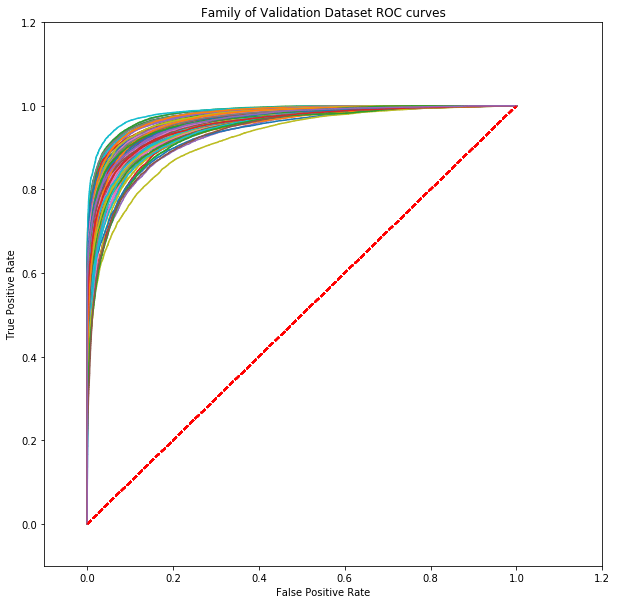

In [25]:
## plot all the validation dataset ROC curves
plt.figure(figsize=(10,10))
plt.title('Family of Validation Dataset ROC curves')
for ind in range(len(all_fpr)):
    
    plt.plot(all_fpr[ind], all_tpr[ind])
    #plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.yscale('log')
#     plt.xscale('log')
    
plt.show()

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


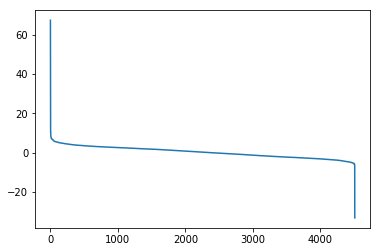

In [26]:
plt.plot(all_thresh[0])

In [27]:
model_path = 'runs/debug/for_paper/MS_bgrn_model_e{}_b{}_no_aug_GPUPAR.pt'.format(epoch_i, bsize)
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


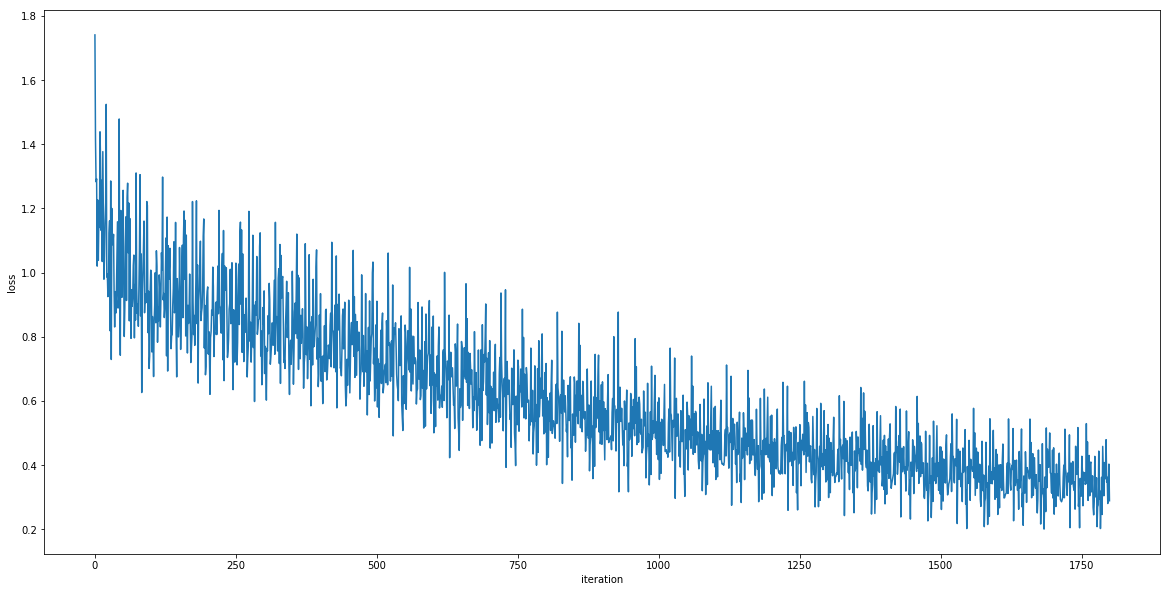

In [28]:
# plot the losses epoch losses from the last 66/100 epochs
# (forgot to record from epoch 0 since I was going in epoch chunks... it is faster with the GPU!!)
plt.figure(figsize=(20,10))
plt.plot([l.data.cpu().numpy() for l in losses])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# plt.plot([l.data.cpu().numpy() for ls in losses_ep for l in ls])
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()


/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


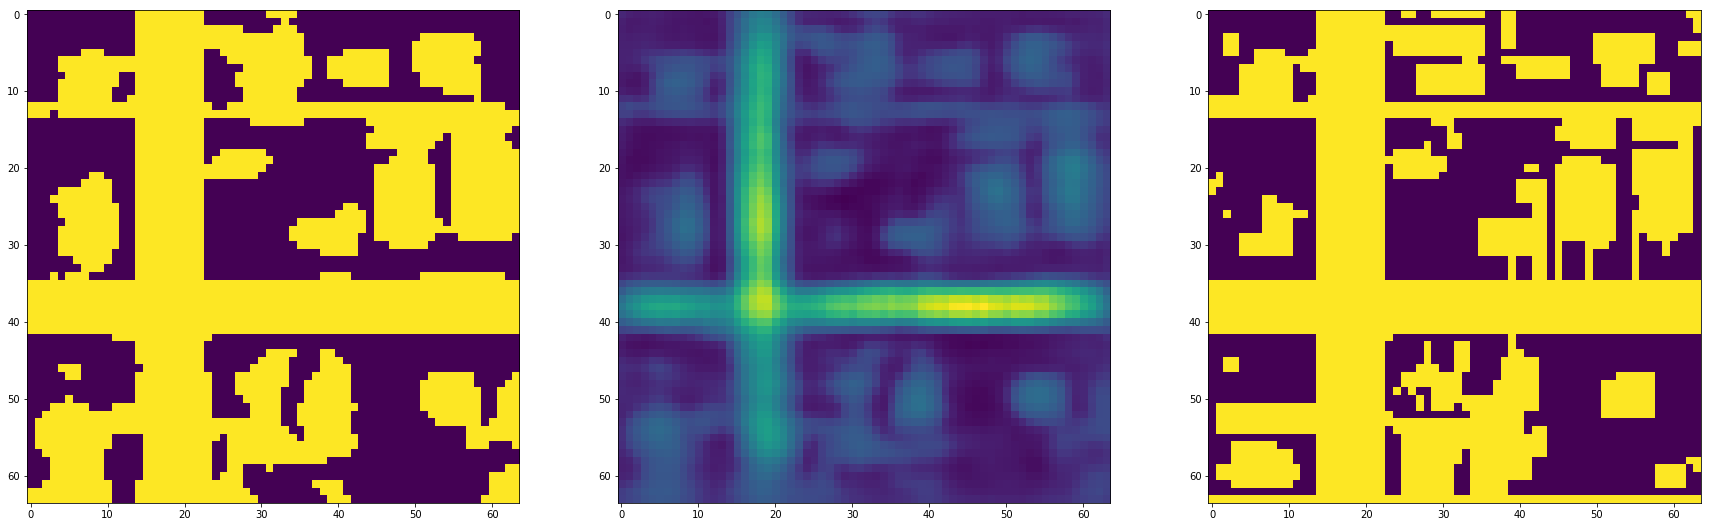

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


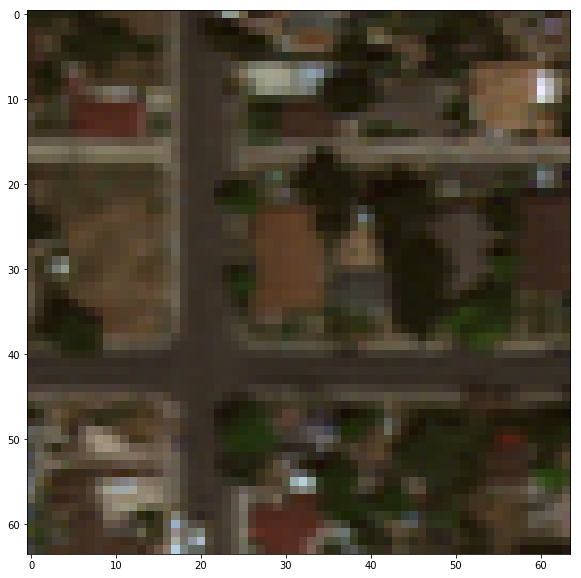

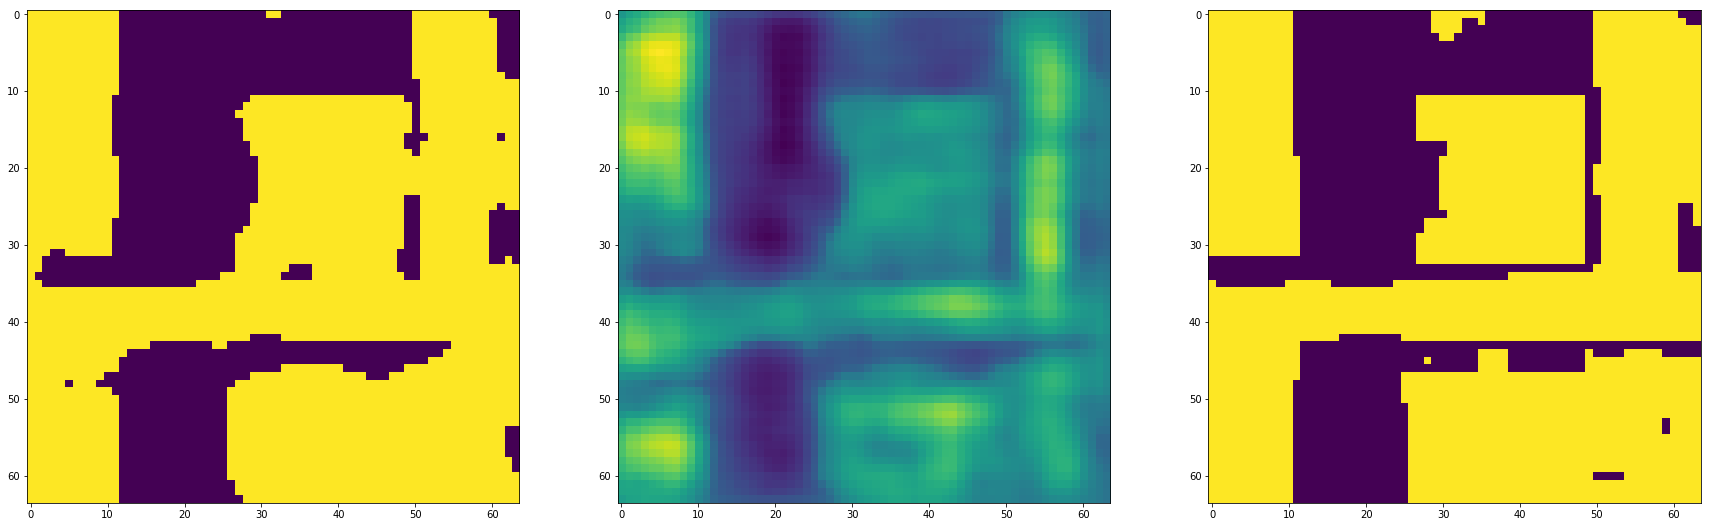

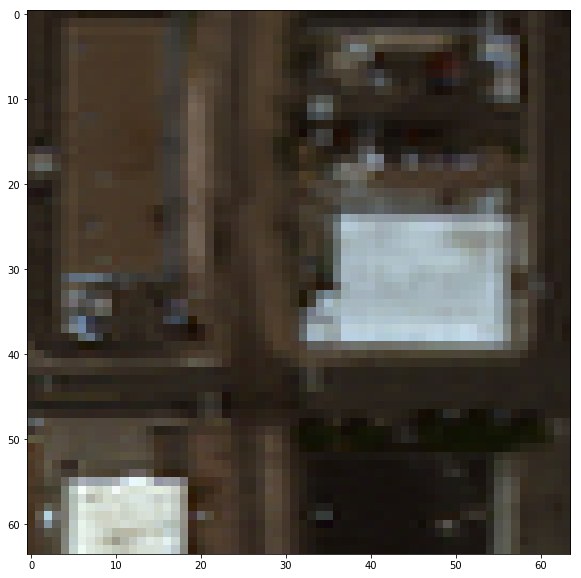

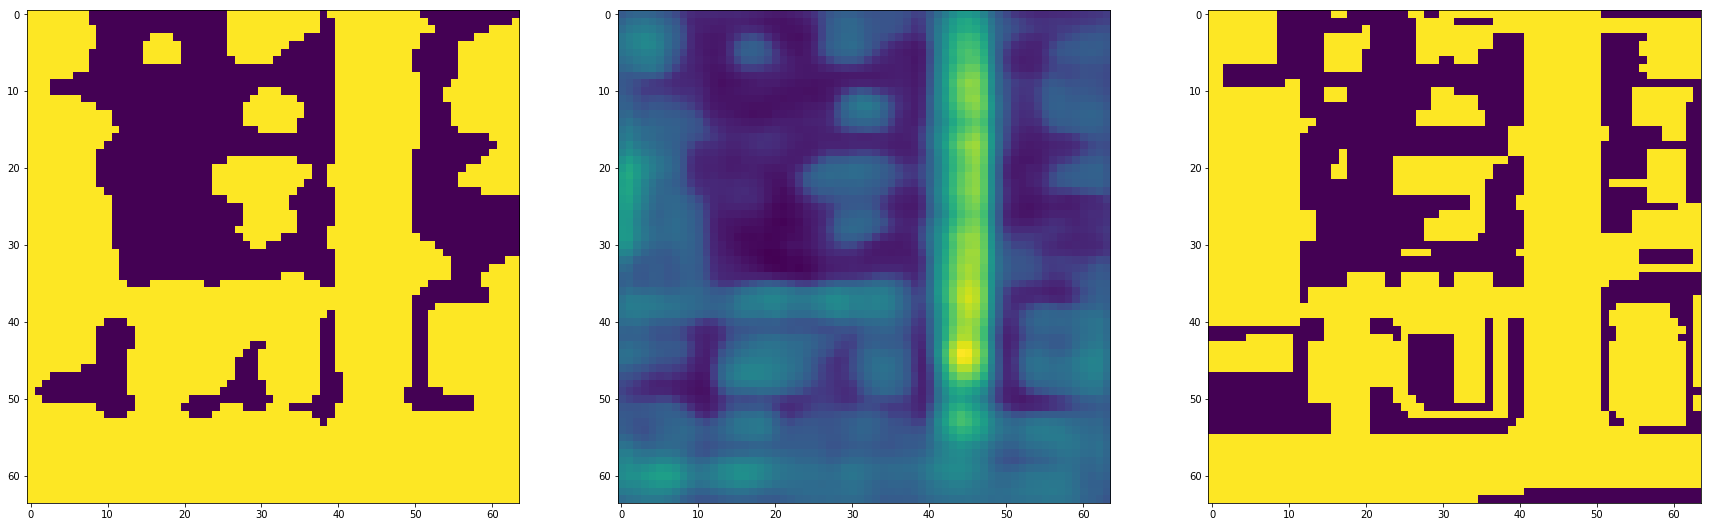

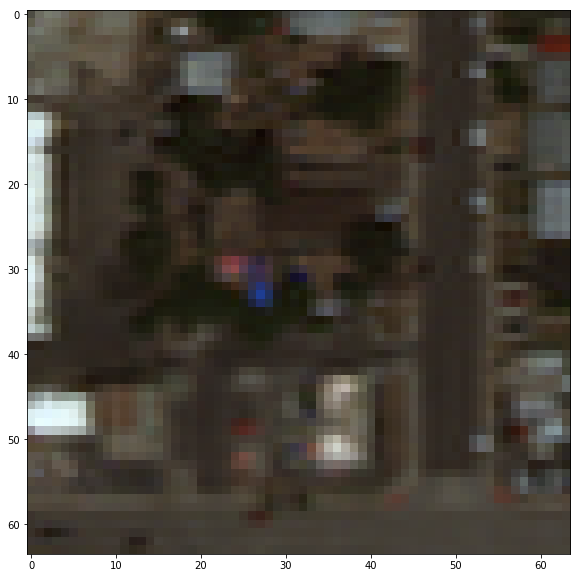

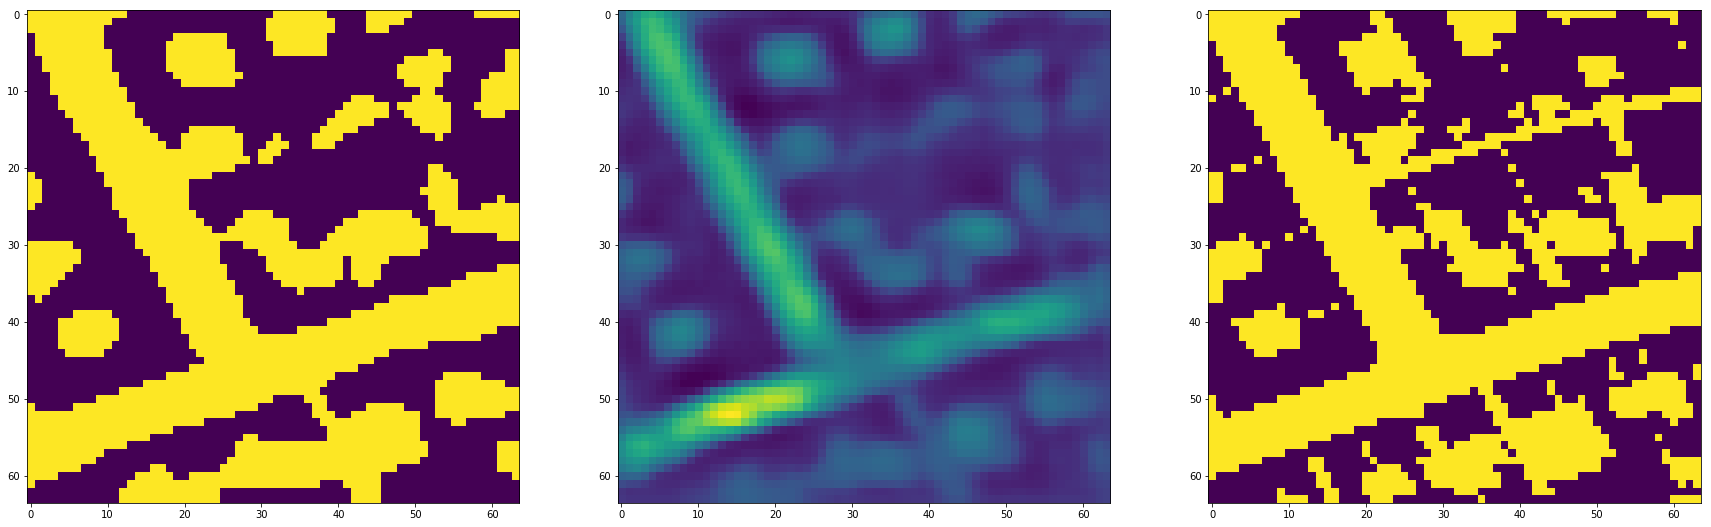

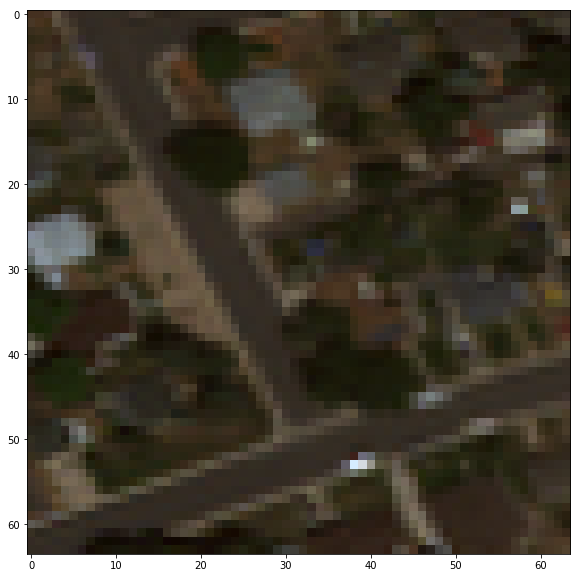

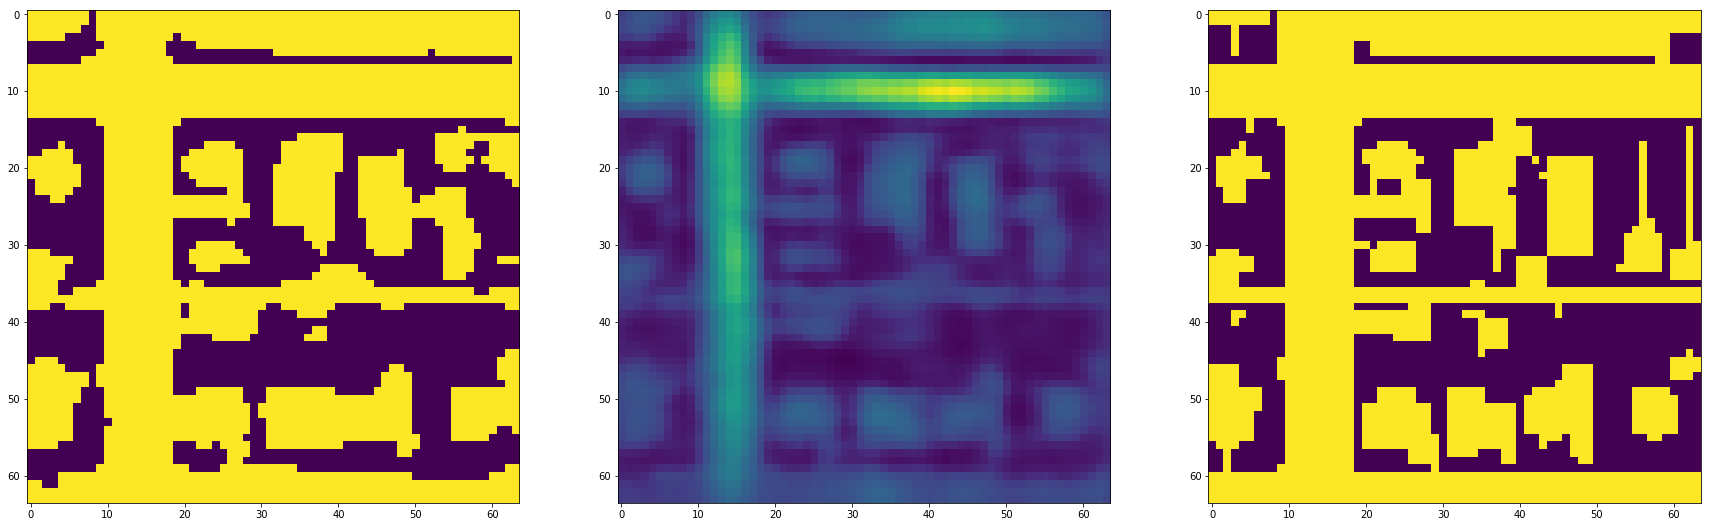

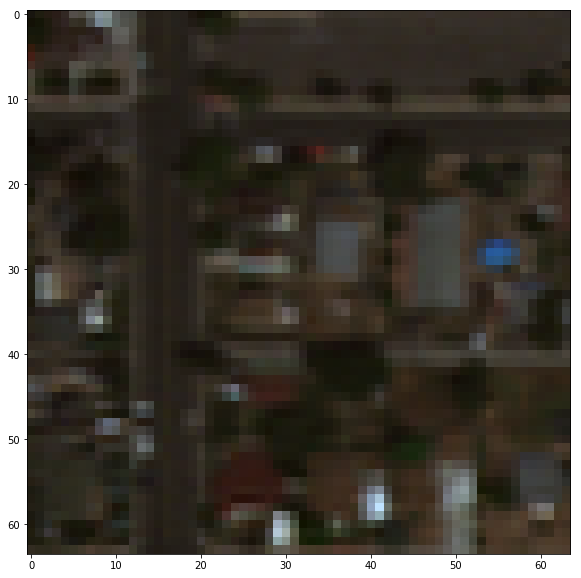

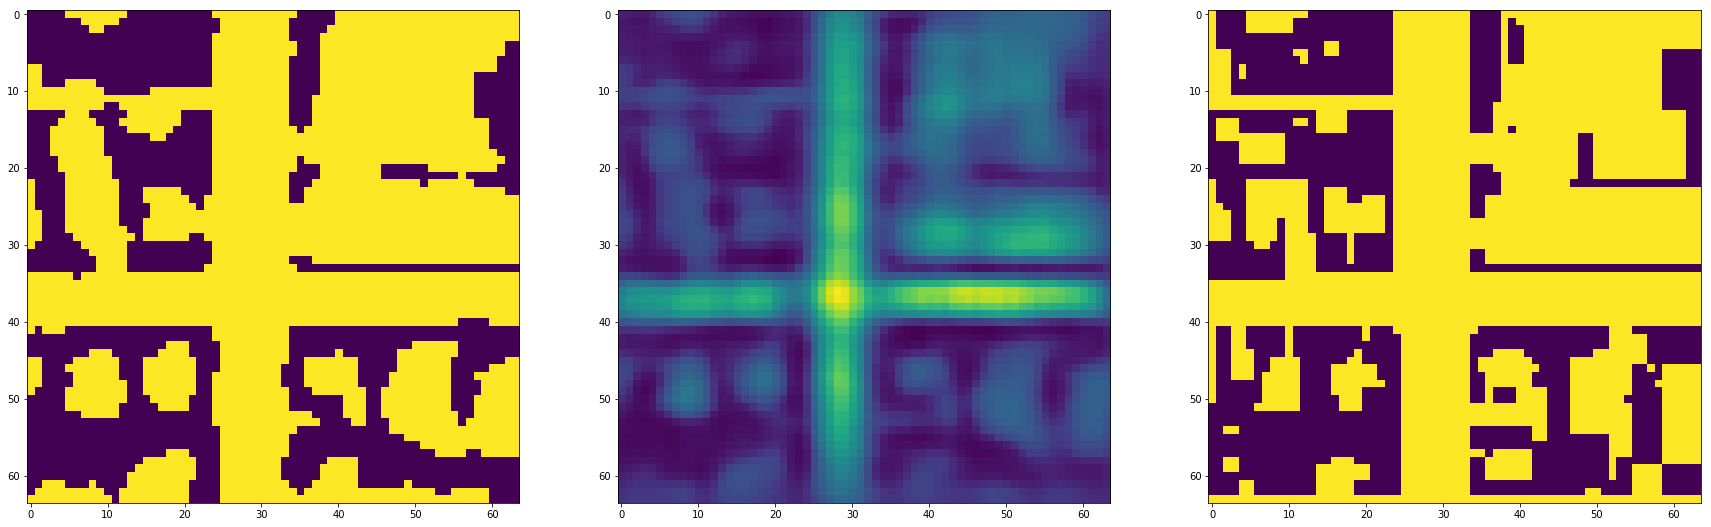

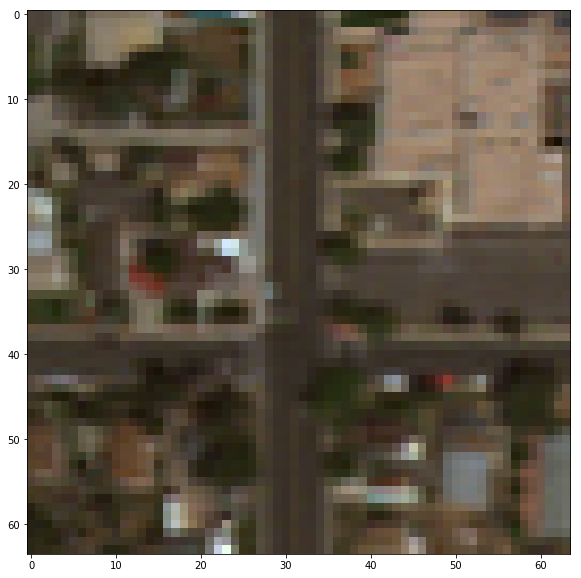

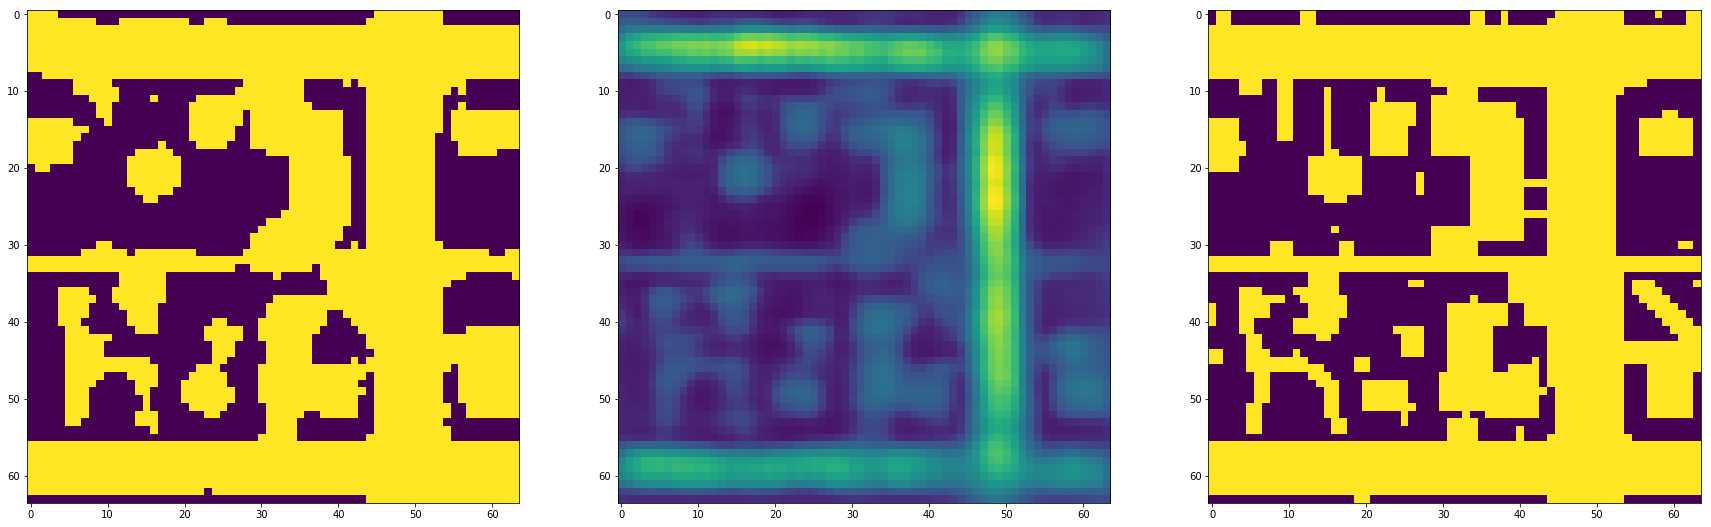

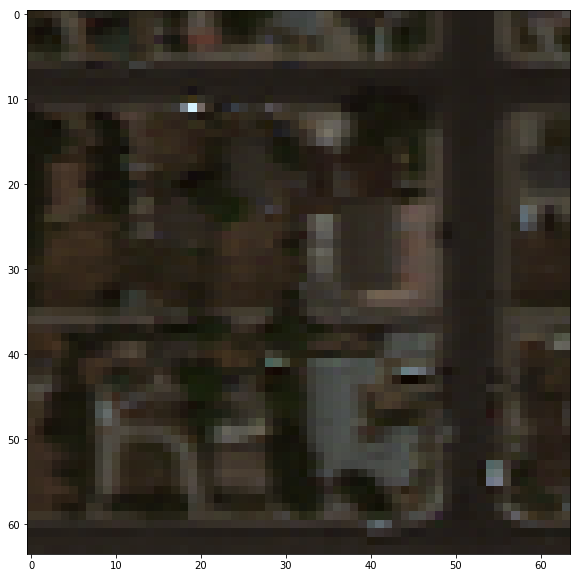

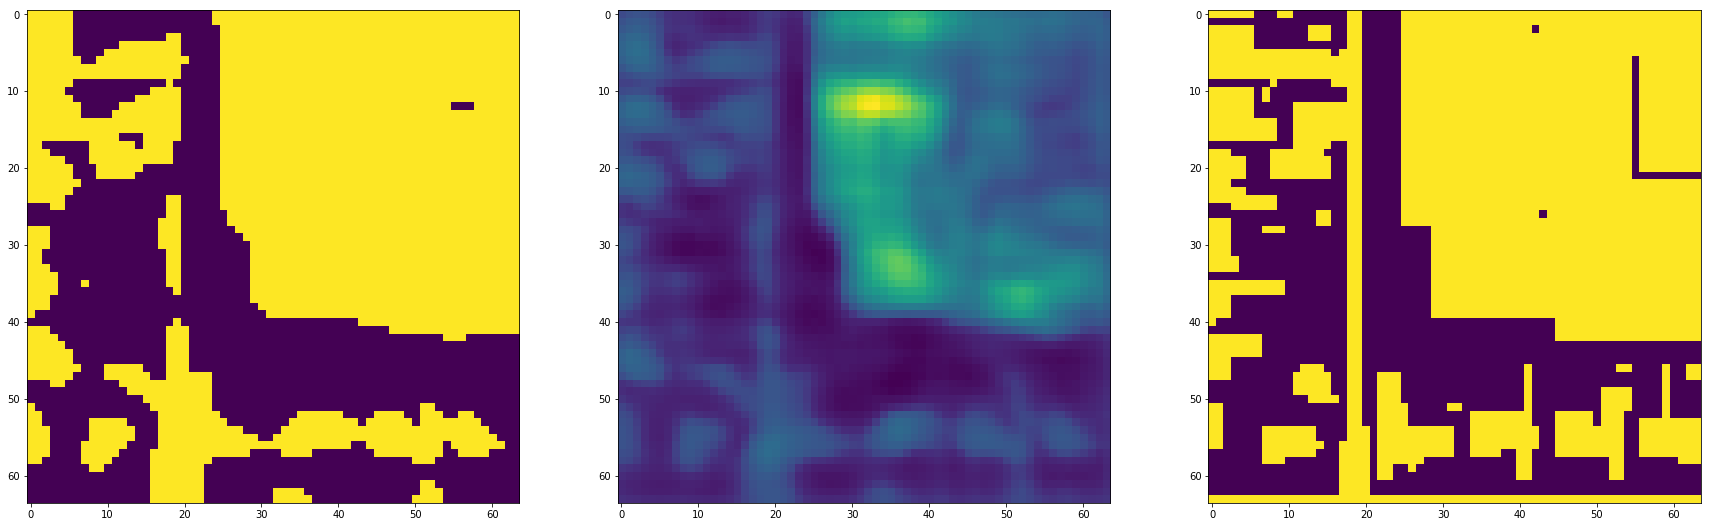

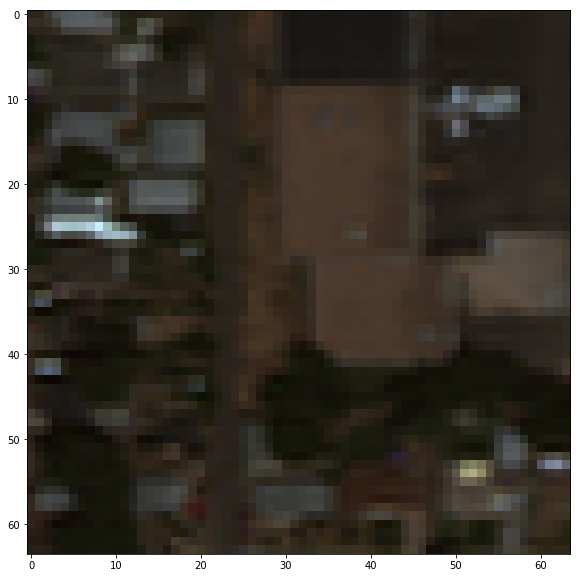

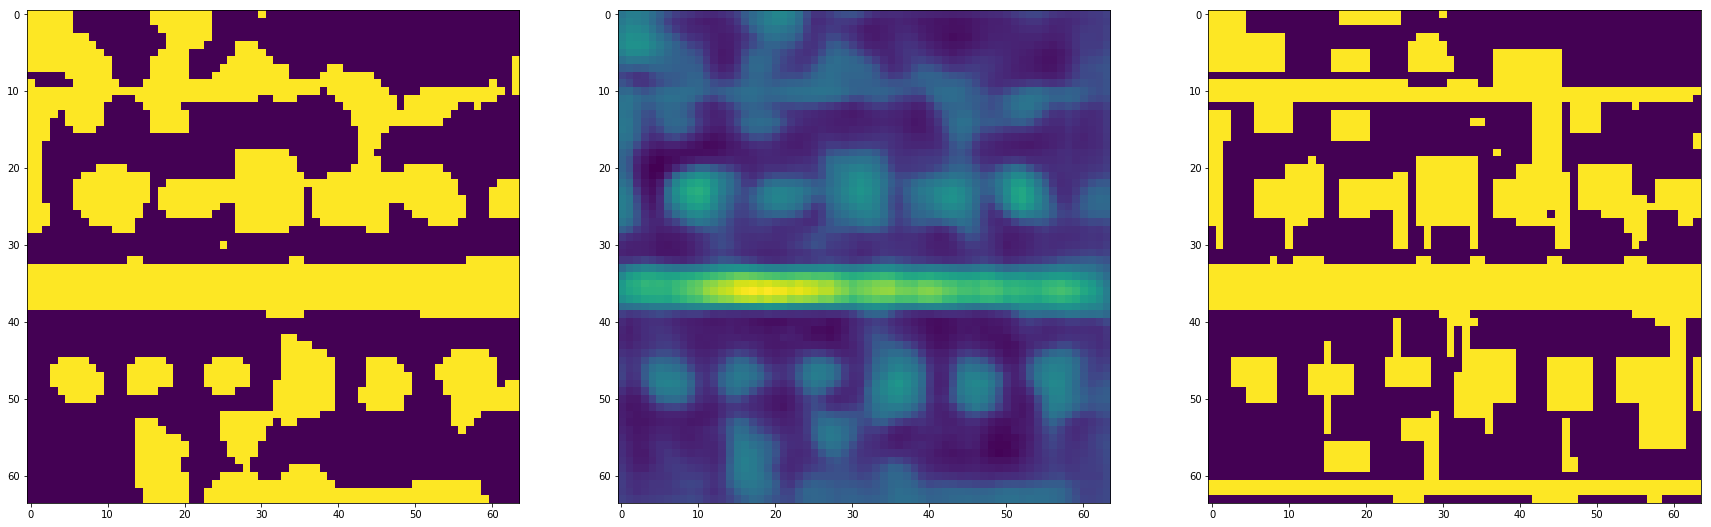

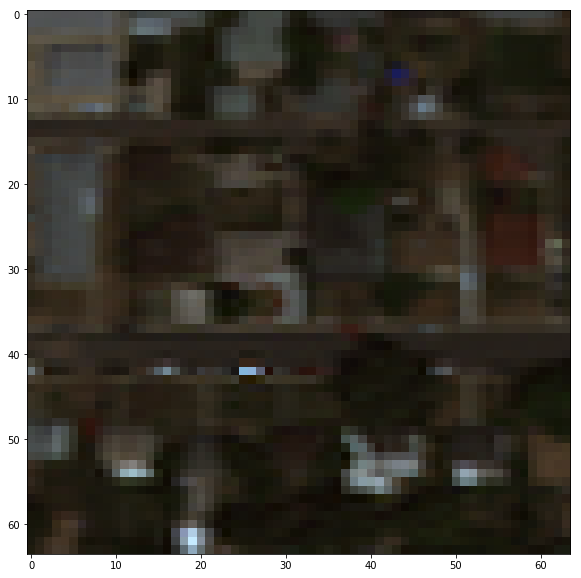

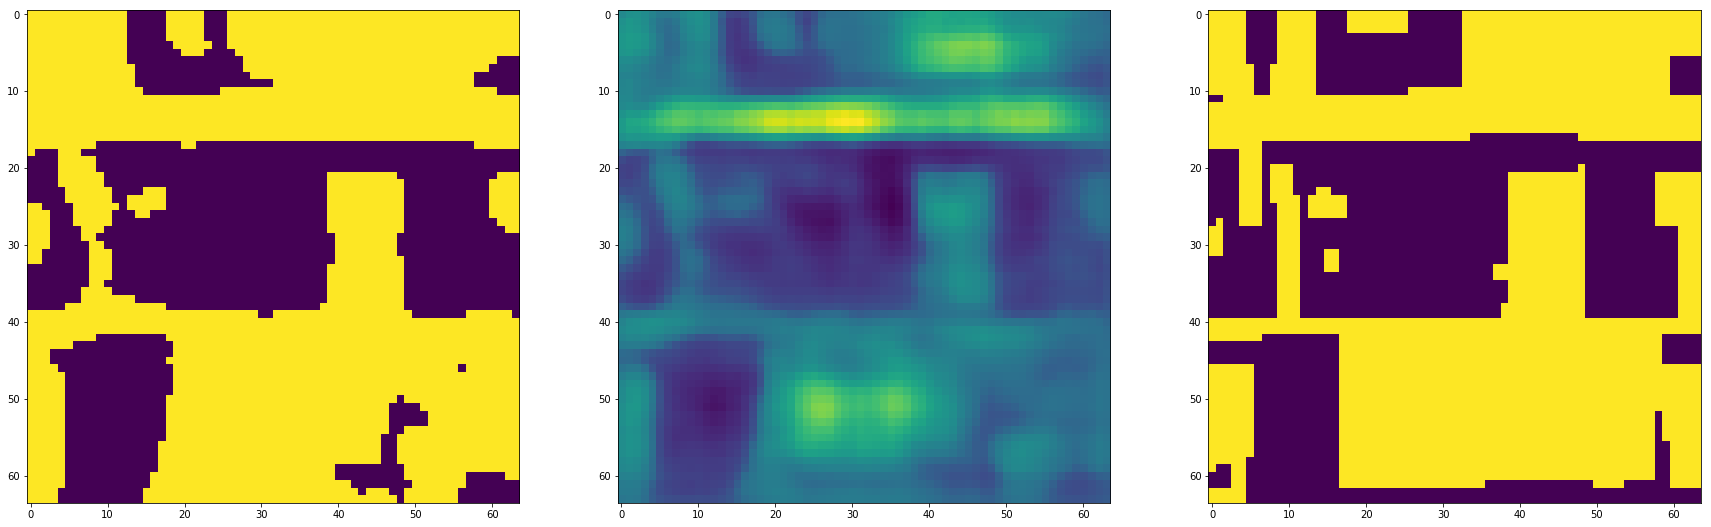

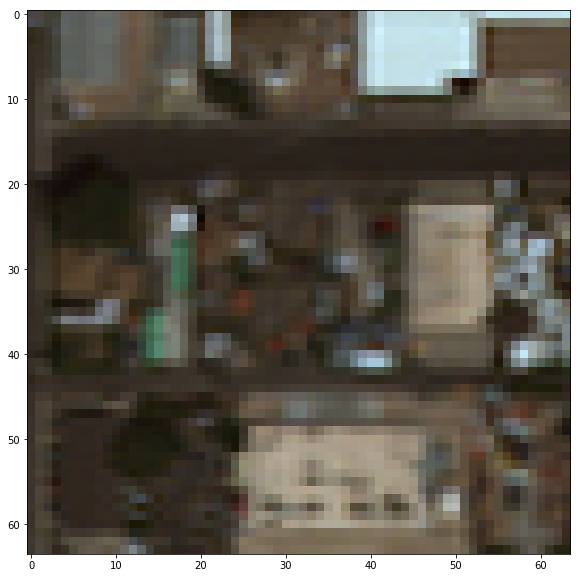

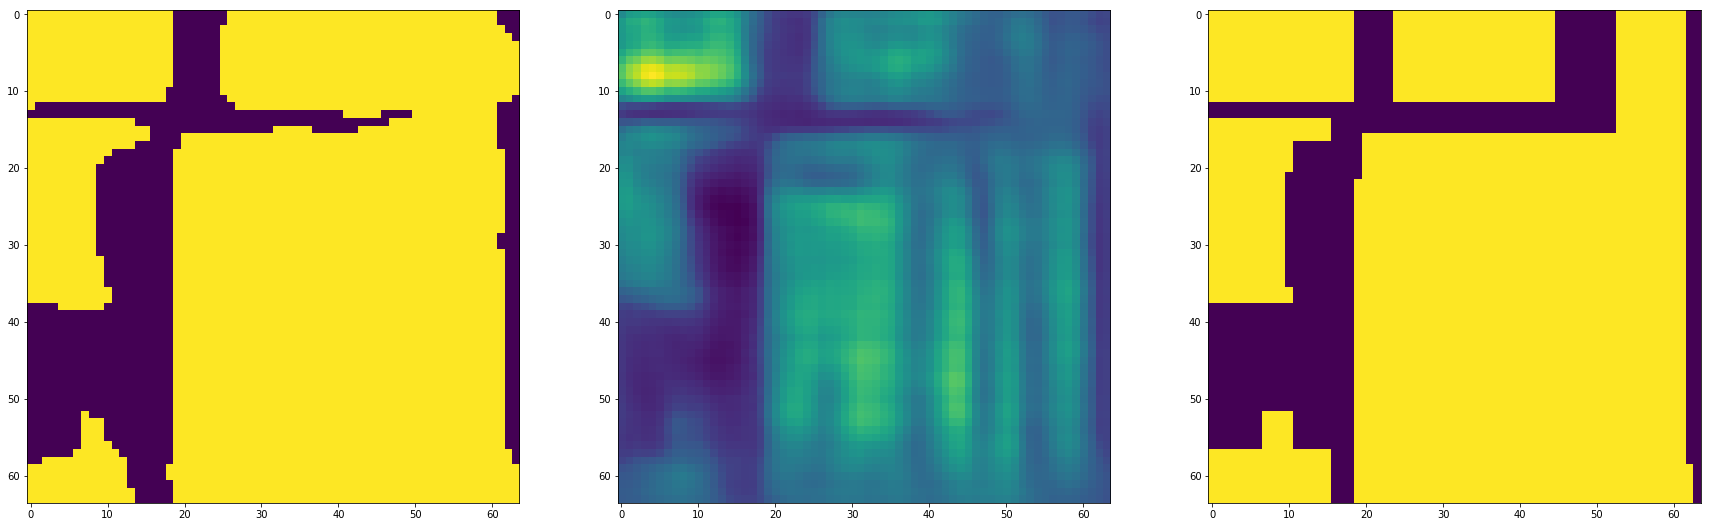

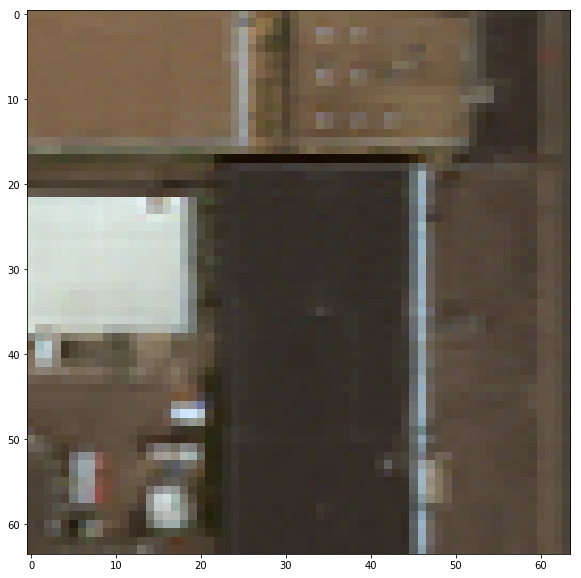

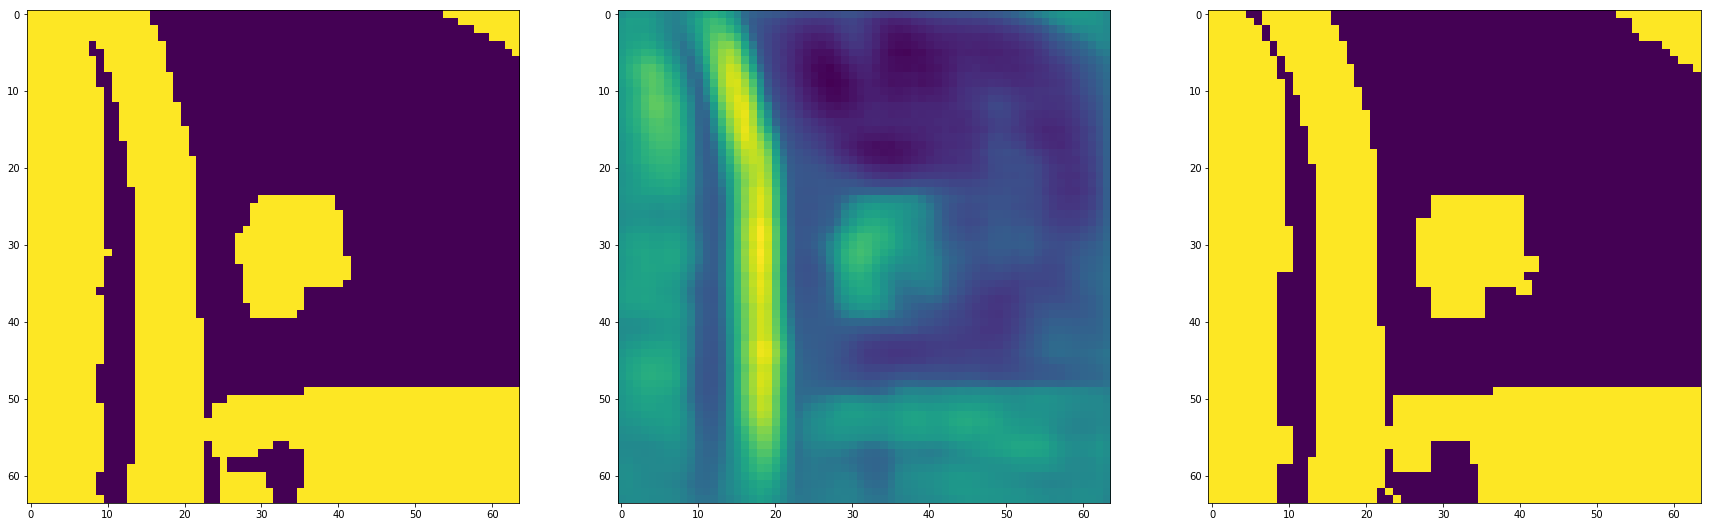

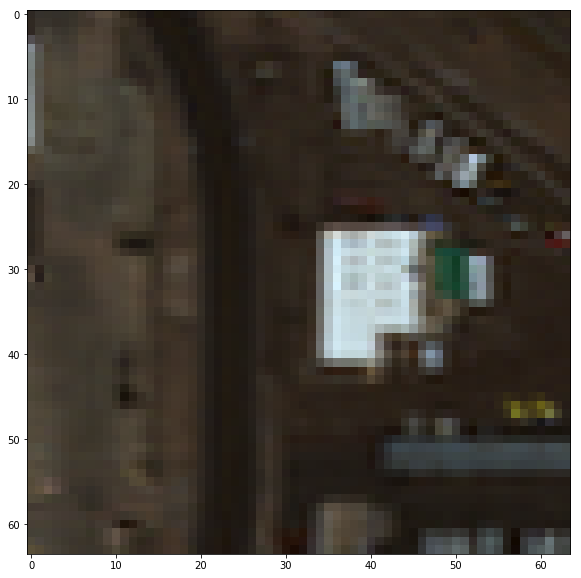

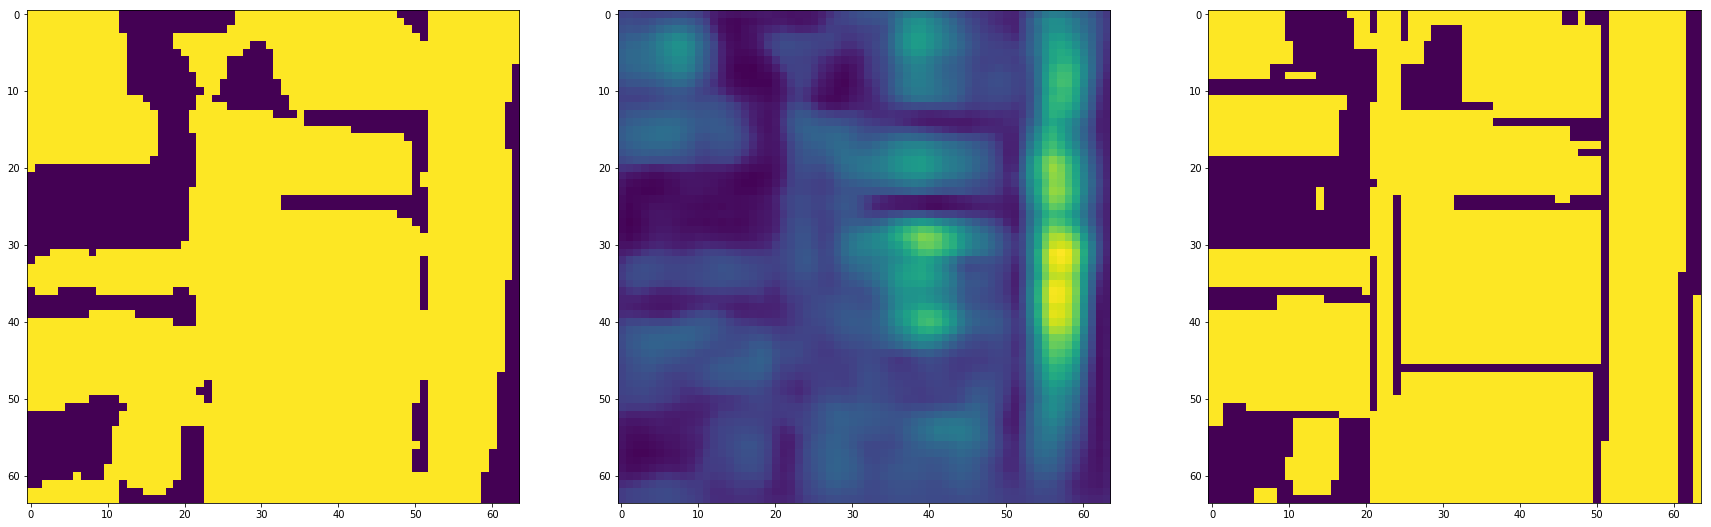

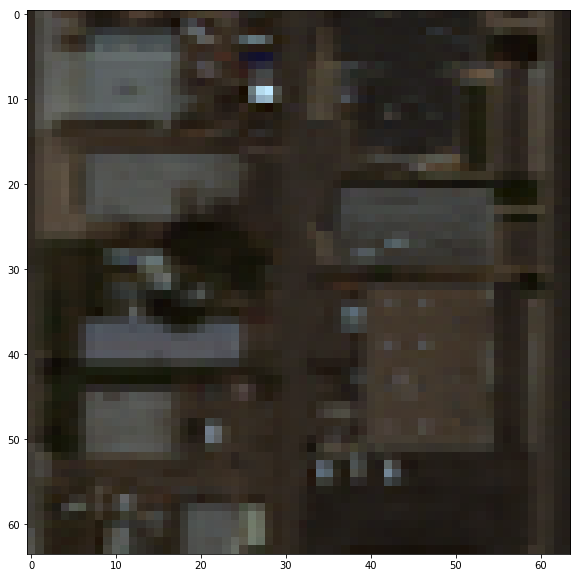

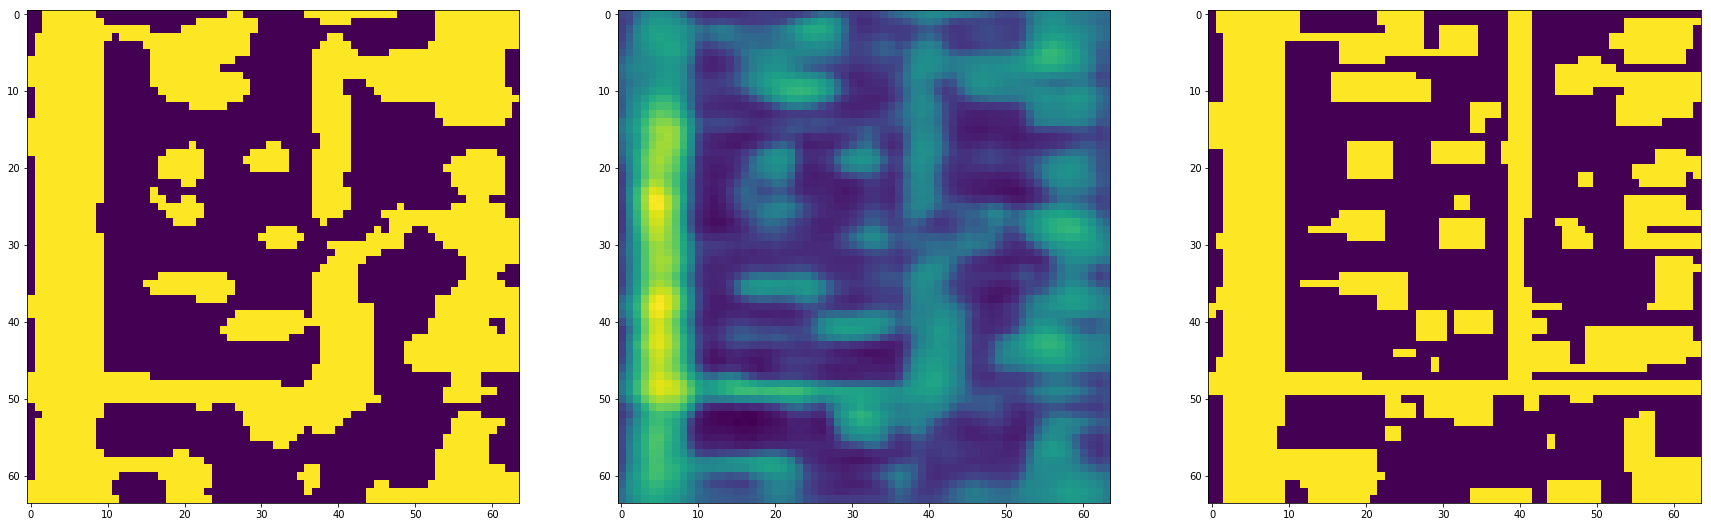

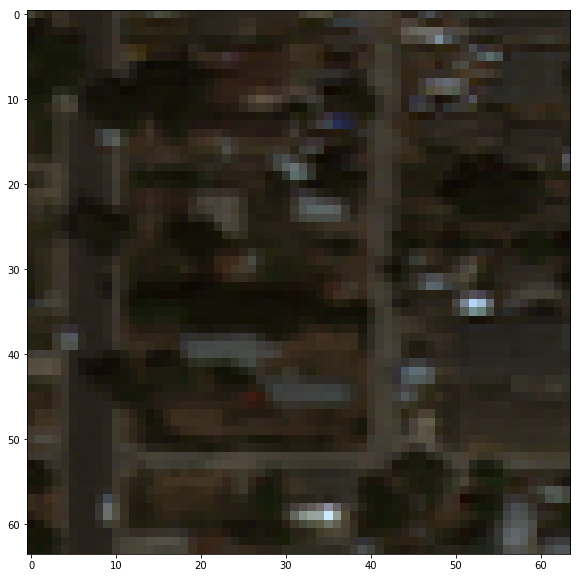

In [29]:
# check one of the test images
test_inds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
for test_ind in test_inds:
    
    try:
        input_img = torch.unsqueeze(variable(dg_dataset_test[test_ind], volatile=True), dim=0) 
        mask = model(input_img)


        mask_im = mask.squeeze().data.cpu().numpy()
        mask_binary = mask_im.copy()

        fig, ax = plt.subplots(1,3, figsize=(30,10))
        thresh = 0
        mask_binary[mask_im<=thresh] = 0
        mask_binary[mask_im>thresh] = 1
        ax[0].imshow(mask_binary)
        # ax[0].colorbar()
        ax[1].imshow(mask_im)
        gt_im = gt_dataset_test[test_ind].numpy().squeeze()
        ax[2].imshow(gt_im)
        # ax[1].colorbar()
        plt.show()

        fig = plt.figure(figsize=(10,10))
        source_im = dg_dataset_test[test_ind].numpy()
        #plt.imshow(misc.bytescale(np.rollaxis(source_im[[4,2,1],:,:], 0, 3)))
        plt.imshow(misc.bytescale(np.rollaxis(source_im[[2,1,0],:,:], 0, 3)))
        plt.show()
    
    except Exception as e:
        print(e)
        pass


In [30]:
# # temp code to keep running overnight
# timeout = time.time() + 60*60*12   # 5 hours from now
# while True:
#     test = 0
#     time.sleep(1)
#     if test == 5 or time.time() > timeout:
#         break
#     test = test - 1

In [31]:
# # save current state
# save = lambda ep: torch.save({
#         'model': model.state_dict(),
#         'epoch': ep,
#         'step': step,
#     }, str(model_path))

# root = Path('runs/debug')
# model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
# ep=epoch
# step=i

# save(ep)

In [32]:
# #load model
# if model_path.exists():
#     state = torch.load(str(model_path))
#     epoch = state['epoch']
#     step = state['step']
#     model.load_state_dict(state['model'])
#     print('Restored model, epoch {}, step {:,}'.format(epoch, step))